In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
import emcee
#import sedfitter

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print np.__version__

import winsound

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
1.13.3
Dependencies imported


Let's now initialize the object class.

In [2]:
#Calculate zero-magnitude flux densities for Gaia data
G_ZP_Vega = 25.6883657251
GBp_ZP_Vega = 25.3513881707
GRp_ZP_Vega = 24.7619199882
        
G_ZP_AB = 25.7933969562
GBp_ZP_AB = 25.3805596387
GRp_ZP_AB = 25.1161276701

G_f0_AB = 10.**(0.4*G_ZP_AB)
GBp_f0_AB = 10.**(0.4*GBp_ZP_AB)
GRp_f0_AB = 10.**(0.4*GRp_ZP_AB)
        
G_Jy_per_photon = 3631./G_f0_AB
GBp_Jy_per_photon = 3631./GBp_f0_AB
GRp_Jy_per_photon = 3631./GRp_f0_AB
        
G_f0_Vega_photon = 10.**(0.4*G_ZP_Vega)
GBp_f0_Vega_photon = 10.**(0.4*GBp_ZP_Vega)
GRp_f0_Vega_photon = 10.**(0.4*GRp_ZP_Vega)
        
G_f0_vega = G_Jy_per_photon * G_f0_Vega_photon
GBp_f0_vega = GBp_Jy_per_photon * GBp_f0_Vega_photon
GRp_f0_vega = GRp_Jy_per_photon * GRp_f0_Vega_photon

#Initialize filter information--zero magnitude flux densities, central wavelengths, names
filterzps = [G_f0_vega, GBp_f0_vega, GRp_f0_vega, 4000.87, 3597.28, 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.673, 0.532, 0.797, 0.4361, 0.5448, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]
filternames = ['G','GBp','GRp','B','V','J','H','K','W1','W2','W3','W4']

filterzps_nogaia = [G_f0_vega, 4000.87, 3597.28, 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav_nogaia = [0.673, 0.4361, 0.5448, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]
filternames_nogaia = ['G','B','V','J','H','K','W1','W2','W3','W4']

filterzps_noJohnson = [G_f0_vega, GBp_f0_vega, GRp_f0_vega, 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav_noJohnson = [0.673, 0.532, 0.797, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]
filternames_noJohnson = ['G','GBp','GRp','J','H','K','W1','W2','W3','W4']

#filternamevec = ['PSg','PSr','PSi','PSz','PSy','Gaia','BJohnson','VJohnson','SDSSg','SDSSr','SDSSi','J','H','K','W1','W2','W3','W4']
#filterzps = [3631., 3631., 3631., 3631., 3631., 2861.3, 4000.87, 3597.28, 3631., 3631., 3631., 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
#filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 0.673, 0.4361, 0.5448, 0.4770, 0.6231, 0.7625, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

#filterzps_short = filterzps[-7:]
#filterzps_nops = filterzps[5:]
#filterzps_nogaia = filterzps[6:]

#Map central wavelengths to zero-magnitude flux densities
filterzps_dict = {filtercentwav[i]: filterzps[i] for i in range(len(filtercentwav))}

class FullSubject:
    #Class for FullSubject object containing all data on a given target
    
    def __init__(self, vec):
        '''Input: vec from DD database output
        
        Purpose: read data from DD database, calculate fluxes for each filter, get nuFnu, initialize spaces for 
        fit parameters'''
        
        #Read data in from vector
        self.zooniverse_id = vec[0]
        self.wiseid = vec[1]
        self.ra = float(vec[2])
        self.dec = float(vec[3])
        #self.glong = float(vec[9])
        #self.glat = float(vec[10])

        self.jmag = float(vec[14])
        self.jmagerr = float(vec[15])
        self.hmag = float(vec[16])
        self.hmagerr = float(vec[17])
        self.kmag = float(vec[18])
        self.kmagerr = float(vec[19])
        tempw1mag = float(vec[20])
        tempw1magerr = float(vec[21])
        tempw2mag = float(vec[22])
        tempw2magerr = float(vec[23])
        self.w3mag = float(vec[24])
        self.w3magerr = float(vec[25])
        self.w4mag = float(vec[26])
        self.w4magerr = float(vec[27])
        
        #Correct W1 fluxes for saturation
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
        
        #Correct W2 fluxes for saturation
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5
        
        self.sourcevec = vec
        
        self.gaia_gmag = float(vec[4])
        self.gaia_gmagerr = float(vec[5])

        self.use_gaia = False
        self.use_Johnson = False
        
        #Read in Gaia data
        if not (math.isnan(float(vec[6]))):
            self.gaia_bpmag = float(vec[6])
            self.gaia_bpmagerr = float(vec[7])
            self.gaia_rpmag = float(vec[8])
            self.gaia_rpmagerr = float(vec[9])
            self.use_gaia = True
            
        if not (math.isnan(float(vec[10]))):
            self.Bmag = float(vec[10])
            self.Bmagerr = float(vec[11])
            self.Vmag = float(vec[12])
            self.Vmagerr = float(vec[13])
            self.use_Johnson = True
            
        #print vec[6]
        #print vec[10]
        #print self.use_Johnson
        #print self.use_gaia
        #print (self.use_Johnson and self.use_gaia)
        #print (not self.use_Johnson)
        #print (not self.use_gaia)
        
        #Set up vector for calculating fluxes from magnitudes
        if (self.use_Johnson and self.use_gaia):
            self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
            self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
            self.filterzps_to_use_temp = filterzps
            self.filtercentwav_to_use_temp = filtercentwav
            self.filts_to_use_temp = filternames
        
        if (not self.use_Johnson):
            self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
            self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
            self.filterzps_to_use_temp = filterzps_noJohnson
            self.filtercentwav_to_use_temp = filtercentwav_noJohnson
            self.filts_to_use_temp = filternames_noJohnson

        if (not self.use_gaia):
            self.mags_to_use_temp = [self.gaia_gmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
            self.magerrs_to_use_temp = [self.gaia_gmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
            self.filterzps_to_use_temp = filterzps_nogaia
            self.filtercentwav_to_use_temp = filtercentwav_nogaia
            self.filts_to_use_temp = filternames_nogaia


            
        print self.filts_to_use_temp

        
        #self.filts_to_use = np.array(self.filts_to_use_temp)
        self.mags_to_use = np.array(self.mags_to_use_temp)
        self.magerrs_to_use = np.array(self.magerrs_to_use_temp)
        
        self.fluxes_to_use_temp = []
        self.fluxerrs_to_use_temp = []
        
        #Convert to janskys
        for i in range(len(self.filterzps_to_use_temp)):
            self.fluxes_to_use_temp.append(self.filterzps_to_use_temp[i] * 10.**(-0.4*self.mags_to_use[i]))
            self.fluxerrs_to_use_temp.append(self.fluxes_to_use_temp[-1] * np.log(10) * 0.4 * self.magerrs_to_use[i])
        
        #Convert to ergs/s/cm**2/Hz
        self.fluxes_to_use = np.array(self.fluxes_to_use_temp) * 1.e-23
        self.fluxerrs_to_use = np.array(self.fluxerrs_to_use_temp) * 1.e-23
        
        #Get wavelengths, calculate nuFnu
        self.centwavs_microns_to_use = np.array(self.filtercentwav_to_use_temp)
        self.centwavs_meters_to_use = self.centwavs_microns_to_use * 1.e-6
        self.centwavs_Hz_to_use = c/self.centwavs_meters_to_use
        self.nuFnu_to_use = self.centwavs_Hz_to_use * self.fluxes_to_use
        self.nuFnuerrs_to_use = self.centwavs_Hz_to_use * self.fluxerrs_to_use
        self.filterzps_to_use = np.array(self.filterzps_to_use_temp)
        self.filts_to_use = np.array(self.filts_to_use_temp)
        
        #self.centwavs_microns = self.centwavs_microns_long[-7:]
        #self.centwavs_meters = self.centwavs_microns * 1.e-6
        #self.centwavs_Hz = c/self.centwavs_meters
        #self.mags = self.mags_long[-7:]
        #self.magerrs = self.magerrs_long[-7:]
        #self.nuFnu = self.nuFnu_long[-7:]
        #self.nuFnuerrs = self.nuFnuerrs_long[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        #Initialize fit parameters
        self.Teff = None
        self.Teff_err_low = None
        self.Teff_err_high = None
        self.logg = None
        self.logg_err_low = None
        self.logg_err_high = None
        self.rdstar = None
        self.rdstar_err_low = None
        self.rdstar_err_high = None
        self.Tdisk = None
        self.Tdisk_err_low = None
        self.Tdisk_err_high = None
        self.xdisk = None
        self.xdisk_err_low = None
        self.xdisk_err_high = None
        self.fir = None
        self.fir_err_low = None
        self.fir_err_high = None
        
        self.nuFnu_star = None
        self.nuFnu_disk = None
        
        self.nuFnu_star_plotting_temp = None
        self.nuFnu_disk_plotting_temp = None
        self.nuFnu_disk1_plotting_temp = None
        self.nuFnu_disk2_plotting_temp = None
        self.nuFnu_model_plotting_temp = None

        self.nuFnu_disk_plotting_temp_powerlaw = None
        self.nuFnu_model_plotting_temp_powerlaw = None
        self.nuFnu_disk_plotting_temp_blackbody = None
        self.nuFnu_model_plotting_temp_blackbody = None
        
        self.nuFnu_star_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None        
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_star_fit = False
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None
        
        self.fitfail = False
        
        self.use_models = False
        
        self.log10Teffguess = None
        self.log10rdstarguess = None
        self.Teffguess = None
        self.logg_guess = None
        self.log10Tdiskguess = None
        self.log10xdiskguess = None
        
        self.filter_cut = None
        self.sampler = None
        
        self.powerlaw = False
        self.alpha = None
        self.log10beta = None
        self.beta = None
        
        self.alpha_err_low = None
        self.alpha_err_high = None
        
        self.beta_err_low = None
        self.beta_err_high = None
        
        self.alpha_guess = None
        self.log10beta_guess = None
        self.beta_guess = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


Now a very basic function to read in data.

In [3]:
def get_data(filename):
    #Read csv in
    df = pd.read_csv(filename, low_memory = False)
    
    data = df.values
    
    return data

And now the actual meat and potatoes. This reads in the data, and tries out initially plotting the data points, just to see how they lay out at a glance.

7.250268
7.513
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
7.605986
8.88
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
7.384182
7.66
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
10.28003
10.9
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
7.667459
8.02
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
14.93812
nan
False
True
False
True
False
['G', 'GBp', 'GRp', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
16.94973
nan
False
True
False
True
False
['G', 'GBp', 'GRp', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
7.97387
8.25
True
True
True
False
False
['G', 'GBp', 'GRp', 'B', 'V', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']
Subjects read in
AWI0005zyp
J034811.63-744138.5
-12.0 -7.0


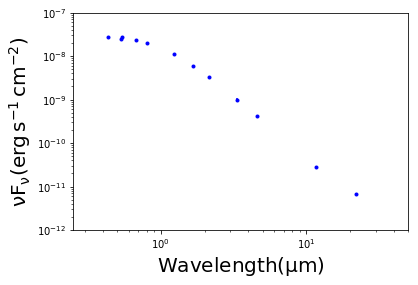

AWI0005zi5
J053739.64-283734.7
-12.0 -7.0


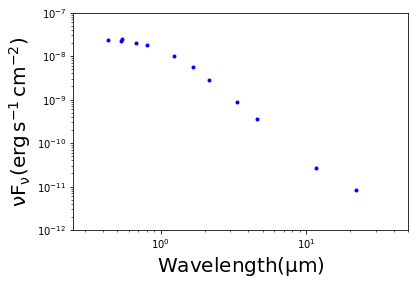

In [4]:
inputdata = get_data('peter_pan_fitting_inputs.csv')
   
inputdata_use = inputdata[0:,:] #Get usable data

num_subjs = inputdata_use[:,0].size #Count subjects

raw_subjs = []

#Initialize subjects
for i in range(num_subjs):
    raw_subjs.append(FullSubject(inputdata_use[i,:]))
    
print "Subjects read in"

#Test a subject
print raw_subjs[0].zooniverse_id
print raw_subjs[0].wiseid

plt.errorbar(raw_subjs[0].centwavs_microns_to_use, raw_subjs[0].nuFnu_to_use, yerr=raw_subjs[0].nuFnuerrs_to_use, fmt='b.')

#Set boundaries on y values
min_nuFnu_logs = min(np.log10(raw_subjs[0].nuFnu_to_use))
max_nuFnu_logs = max(np.log10(raw_subjs[0].nuFnu_to_use))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)

#Plot in log scale
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()


#Plot a second target to test
print raw_subjs[2].zooniverse_id
print raw_subjs[2].wiseid

plt.errorbar(raw_subjs[2].centwavs_microns_to_use, raw_subjs[2].nuFnu_to_use, yerr=raw_subjs[2].nuFnuerrs_to_use, fmt='b.')

min_nuFnu_logs = min(np.log10(raw_subjs[2].nuFnu_to_use))
max_nuFnu_logs = max(np.log10(raw_subjs[2].nuFnu_to_use))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)


plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

Now, a whole bunch of functions to set up the star fitting. In order:

fluxdrive_plot calls import_spectrum to read in a stellar model spectrum.

import_spectrum does the actual reading in.

lnlike_star_blackbody determines the log-likelihood of the $\lambda F_{\lambda}$ values, given the log effective temperature and log-ratio of stellar radius to stellar distance for a blackbody function. This sets up the maximum likelihood estimation.

star_fitter_models cycles through all the possible values of $T_{\mathrm{eff}}$ and $\log(g)$ in the model set, and determines the log-likelihood of the $\lambda F_{\lambda}$ values, using lnlike_rdstar. It then determines which of this set is the most likely.

get_star_fit is the bread and butter. It picks whether to use Bmag and Vmag data (if available) or Gaia data (if Bmag or Vmag isn't). It then does an initial fit based on 2MASS-and-blueward data, as a blackbody. If the result it returns is in range for the stellar models, it then refits with the stellar models. If Kmag is more than $5\sigma$ above the resulting fit, it refits without Kmag. If W1 is not more than $5\sigma$ above, it refits with W1 included, and then does the same thing with W2.

1535223721.31
AWI0005zyp J034811.63-744138.5
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']


C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: invalid value encountered in expm1
  *arrays, **kwargs)


12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 9.78765620393e-10 9.38114347556e-10 9.48182162093e-11 0.428728512961
W1 not in excess. Refitting with W1 included.
-3 4.15372081747e-10 3.80206172671e-10 1.16054718387e-11 3.0301145498
W2 not in excess. Refitting with W2 included.
-2 2.87717170874e-11 2.85251486934e-11 3.97495961192e-13 0.620304149367
8
6700.0 4.5 5.52752948481e-10


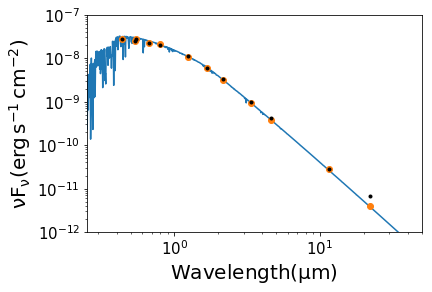

Excess: 3.95408377429e-12 6.7605764875e-12 1.93028352738e-13 14.5392771238
1535223737.1 1 15.7960000038

AWI0005znw J064613.60-835928.7
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 8.20066105293e-10 1.0795276294e-09 6.79271088846e-11 -3.81970509811
W1 not in excess. Refitting with W1 included.
-3 3.52254192226e-10 4.27139233503e-10 7.85806338685e-12 -9.52970695079
W2 not in excess. Refitting with W2 included.
-2 2.52909871677e-11 3.00260014216e-11 3.49407900237e-13 -13.5515374743
2
Model fit is bad stellar fit--will try blackbody fit.
Bad stellar fit when using blackbody as well--will not fit disk.
5800.0 5.5 6.11597722929e-10


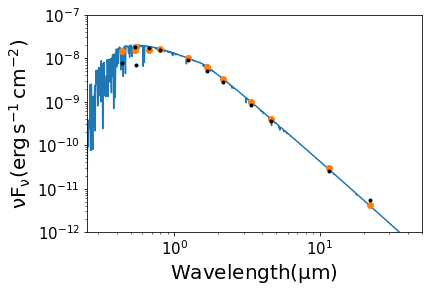

Excess: 4.16596340107e-12 5.61285380661e-12 1.91276287863e-13 7.56440028039
1535223763.23 2 20.9589999914

AWI0005zi5 J053739.64-283734.7
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 8.72838530843e-10 8.55824354795e-10 7.06951898154e-11 0.240669500898
W1 not in excess. Refitting with W1 included.
-3 3.66143187891e-10 3.45578555104e-10 8.10055286618e-12 2.53867027682
W2 not in excess. Refitting with W2 included.
-2 2.6826609111e-11 2.54755866603e-11 3.70623301408e-13 3.64527121084
8
6700.0 5.0 5.23093358882e-10


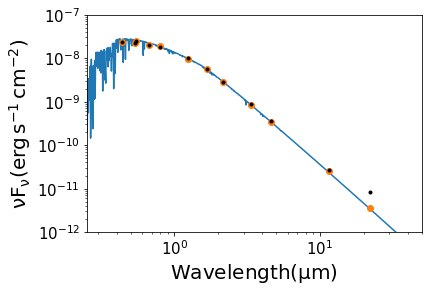

Excess: 3.52811021222e-12 8.47976331787e-12 2.7335527251e-13 18.1143500917
1535223782.02 3 20.2383333047

AWI0000m02 J044115.76-351358.1
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
5
5300.0 5.0 2.45858682229e-10


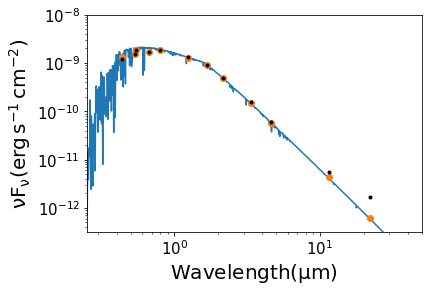

Excess: 6.15112892456e-13 1.67025865416e-12 1.26145935856e-13 8.3644847894
1535223794.08 4 18.1932500005

AWI0000ike J020726.24-594046.2
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 9.12731840631e-10 8.94636444956e-10 8.24416160277e-11 0.219493461508
W1 not in excess. Refitting with W1 included.
-3 4.03247181637e-10 3.59259588035e-10 1.13344939252e-11 3.88086083885
W2 not in excess. Refitting with W2 included.
-2 2.93877124146e-11 2.81564435793e-11 4.06006251138e-13 3.03263516709
7
6000.0 2.5 5.87903449818e-10


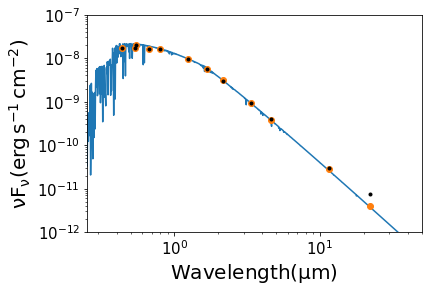

Excess: 3.906571235e-12 7.3991823531e-12 2.38521457812e-13 14.6427543674
1535223817.81 5 19.3006000042

AWI00063nx J094900.65-713803.1
['G' 'GBp' 'GRp' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
Initial fit fail. Adding filter and retrying.
-5
Fit successful.
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 5.5372314148e-11 4.11524667421e-11 1.12199529307e-12 12.6737139574
4
3500.0 3.0 1.79867044773e-10


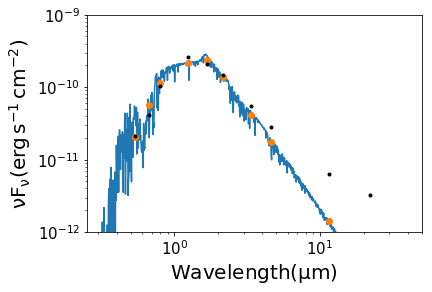

Excess: 2.14134640718e-13 3.24476860027e-12 1.10576065976e-13 27.4076847716
1535223837.05 6 19.2903333108

AWI000601p J044634.16-262756.1
['G' 'GBp' 'GRp' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']


C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: divide by zero encountered in true_divide
  *arrays, **kwargs)
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: invalid value encountered in multiply
  *arrays, **kwargs)
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: invalid value encountered in greater
  *arrays, **kwargs)
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: invalid value encountered in greater_equal
  *arrays, **kwargs)
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:380: RuntimeWarning: overflow encountered in double_scalars


Initial fit fail. Adding filter and retrying.
-5
Fit successful.
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 2.62840735714e-11 1.65796311337e-11 5.56796107096e-13 17.429077384
2
Model fit is bad stellar fit--will try blackbody fit.
Bad stellar fit when using blackbody as well--will not fit disk.
3100.0 2.5 1.39875320601e-10


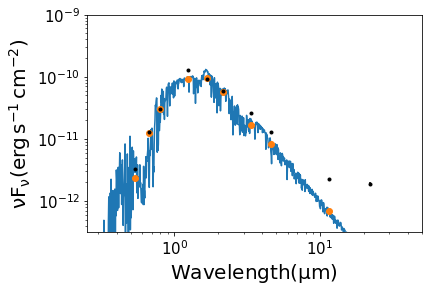

Excess: 1.07613292859e-13 1.86030318945e-12 1.28505191774e-13 13.6390590325
1535223865.61 7 20.613857133

AWI000601q J044649.55-261808.8
['G' 'GBp' 'GRp' 'B' 'V' 'J' 'H' 'K' 'W1' 'W2' 'W3' 'W4']
12
0 G 6.73e-07 3296.20152879
1 GBp 5.32e-07 3534.74152368
2 GRp 7.97e-07 2620.25269387
3 B 4.361e-07 4000.87
4 V 5.448e-07 3597.28
5 J 1.235e-06 1594.0
6 H 1.662e-06 1024.0
7 K 2.159e-06 666.7
8 W1_W10 3.35e-06 309.54
9 W2_W10 4.6e-06 171.787
10 W3_W10 1.156e-05 31.674
11 W4_W10 2.208e-05 8.363
K not in excess. Refitting with K included.
-4 4.95503386987e-10 4.78618010322e-10 2.89813467785e-11 0.582629123276
W1 not in excess. Refitting with W1 included.
-3 2.00564085067e-10 1.9397805061e-10 3.87925332871e-12 1.69775827951
W2 not in excess. Refitting with W2 included.
-2 1.47151868564e-11 1.43645527992e-11 2.16851007335e-13 1.61693533953
8
6700.0 4.0 3.93335517655e-10


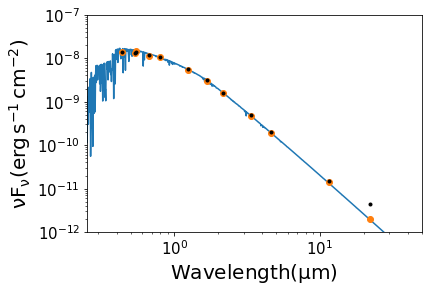

Excess: 1.99301266905e-12 4.52047144945e-12 2.04011895387e-13 12.3887814267
1535223880.81 8 19.9372499883

Star fits done
Time elapsed: 159.498999834
Number good star fits: 8 out of 242
Number good model fits: 8 out of 8
Number good bb fits: 0 out of 0


In [5]:
def fluxdrive_plot(spectname, binsize):
    #Import synthetic spectrum data
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    '''Import synthetic BT-Settl CIFIST spectrum from file'''
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    #Read file in
    with open(spectname) as f:
        spectfilelist = f.readlines()
    
    #Test out line breaks
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

def lnlike_star_blackbody(theta, wav, flux, fluxerr):
    log10Teff, log10rdstar = theta

    Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    
    centwavs_angstroms = wav * 1.e10 * u.AA
    centwavs_meters = wav * u.m
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model = flux_lam * (rdstar**2)
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(fluxerr**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
def star_fitter_blackbody(centwavs, log10Teff, log10rdstar):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    #print log10Teff, log10rdstar
    
    Teff = 10.**(log10Teff)
    rdstar = 10.**(log10rdstar)
    
    #print Teff, rdstar
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    return flux_lam * (rdstar**2)


def get_chi2(mags, magerrs, result_mags):
    chis = np.zeros(mags.size)
    
    for i in range(mags.size):
        chis[i] = ((mags[i] - result_mags[i])**2)/magerrs[i]
        
    sumchis = np.sum(chis)
    
    return sumchis

cent_wavs_dict = {}
    
cent_wavs_dict_keys = np.array([0.673, 0.532, 0.797, 0.4361, 0.5448, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]) * 1.e-6

for i in range(cent_wavs_dict_keys.size):
    cent_wavs_dict[cent_wavs_dict_keys[i]] = i
    
btsettl_column_labels = ['Teff', 'Logg','G','GBp','GRp','B','V','J','H','K','W1_W10','W2_W10','W3_W10','W4_W10']

    
#print cent_wavs_dict

def star_fitter_models(centwavs, mags, magerrs, guess):
    fit_results_dict = {model: None for model in btsettl_models_dict.keys()}
    fit_chi_dict = {model: None for model in btsettl_models_dict.keys()}
    
    magerrs_use = np.array(magerrs)
    
    for i in range(centwavs.size):
        if centwavs[i] == cent_wavs_dict_keys[0]:
            magerrs_use[i] = magerrs[i] * 10.
    
    log10Teff_guess = guess[0]
    Teff_guess = 10.**log10Teff_guess
    difTeffguess = 7000. - Teff_guess
    
    mindifTeffguess = Teff_guess - difTeffguess
    
    log10rdstar_guess = guess[1]
    
    keys_use = []
    
    for model in btsettl_models_dict.keys():
        Teff = model[0]
        logg = model[1]
        
        if Teff < mindifTeffguess:
            continue
        else:
            keys_use.append(model)
            
            def lnlike_rdstar(theta, centwavs, mags, magerrs):
                log10rdstar = theta[0]
                
                magerrs_use = np.array(magerrs)
                
                fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
                fitmagsuse = []
                
                #print centwavs
                
                for i in range(len(centwavs)):
                    #print cent_wavs_dict[centwavs[i]]
                    fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
                    if centwavs[i] == cent_wavs_dict_keys[0]:
                        magerrs_use[i] = 10.*magerrs[i]

                #print fitmagsuse
                
                result_mags = fitmagsuse - 5.*log10rdstar
                
                inv_sigma2 = 1./(magerrs_use**2)
                
                return -0.5*np.sum((((mags - result_mags)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
            nll1 = lambda *args: -lnlike_rdstar(*args)
    
            result1 = minimize(nll1, [log10rdstar_guess], args = (centwavs, mags, magerrs))
        
            log10rdstar_opt = result1["x"][0]
            
            #popt, pcov = curve_fit(fit_rdstar, centwavs, mags, sigma=magerrs)
        
            fit_mags_full = btsettl_models_dict[(Teff, logg)]
            
            #print Teff, logg, log10rdstar_opt
            #print fit_mags_full
            
            fit_mags_use = []
            
            for i in range(len(centwavs)):
                fit_mags_use.append(fit_mags_full[cent_wavs_dict[centwavs[i]]])
                
            fit_result_mags = fit_mags_use - 5.*log10rdstar_opt
            
            #print Teff, logg, log10rdstar_opt
            #print fit_result_mags
            #print mags
            
            fit_results_dict[model] = 10.**log10rdstar_opt
            fit_chi_dict[model] = get_chi2(mags, magerrs_use, fit_result_mags)
            
            #print fit_chi_dict[model]
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    minchi = min(fit_chi_dict_use.values())
    
    best_model = fit_chi_dict_use.keys()[fit_chi_dict_use.values().index(minchi)]
    
    best_rdstar = (fit_results_dict_use[best_model])
    
    return best_model[0], best_model[1], best_rdstar

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

btsettl_df = pd.read_csv('mdwarf_fitting_grid.csv',low_memory=False)
btsettl_data = btsettl_df.values

num_models = btsettl_data[:,0].size

btsettl_models_dict = {}

#print num_models

keylist = []

for i in range(num_models):
    if float(btsettl_data[i,0]) > 2000.:
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
        key = (float(btsettl_data[i,0]), float(btsettl_data[i,1]))
        keylist.append(key)
        btsettl_models_dict[key] = btsettl_data[i,2:]

#for key in keylist:
#    btsettl_models_dict[key] = btsettl_data[i,2:]
    
def get_star_fit(subj):
    #print subj.nuFnu.size
    #print subj.nuFnuerrs.size
    print subj.filts_to_use
    nuFnu_full_use = subj.nuFnu_to_use
    nuFnu_full_err_use = subj.nuFnuerrs_to_use
    mags_full_use = subj.mags_to_use
    magerrs_full_use = subj.magerrs_to_use
    cent_wavs_full_use = subj.centwavs_meters_to_use
    filterzps_full_use = subj.filterzps_to_use
        
        
        #nuFnu_use = subj.nuFnu_nogaia[:-4]
        #nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
        #mags_use = subj.mags_nogaia[:-4]
        #magerrs_use = subj.magerrs_nogaia[:-4]
        #cent_wavs_use = subj.centwavs_meters_nogaia[:-4]
        #filterzps_use = subj.filterzps_nogaia[:-4]
    #elif (subj.jmag < 14.5) and ((subj.jmag - subj.hmag) > 0.):
    #    nuFnu_full_use = subj.nuFnu_long
    #    nuFnu_full_err_use = subj.nuFnuerrs_long
    #    mags_full_use = subj.mags_long
    #    magerrs_full_use = subj.magerrs_long
    #    cent_wavs_full_use = subj.centwavs_meters_long
    #    
    #    nuFnu_use = subj.nuFnu_nogaia[:-4]
    #    nuFnu_err_use = subj.nuFnuerrs_nogaia[:-4]
    #    mags_use = subj.mags_nogaia[:-4]
    #    magerrs_use = subj.magerrs_nogaia[:-4]
    #    cent_wavs_use = subj.centwavs_meters_nogaia[:-4]                
    #else:
    #    nuFnu_full_use = subj.nuFnu_nops
    #    nuFnu_full_err_use = subj.nuFnuerrs_nops
    #    mags_full_use = subj.mags_nops
    #    magerrs_full_use = subj.magerrs_nops
    #    cent_wavs_full_use = subj.centwavs_meters_nops
    #    filterzps_full_use = subj.filterzps_nops
        
        #nuFnu_use = subj.nuFnu_nops[:-3]
        #nuFnu_err_use = subj.nuFnuerrs_nops[:-3]
        #mags_use = subj.mags_nops[:-3]
        #magerrs_use = subj.mags_nops[:-3]
        #cent_wavs_use = subj.centwavs_meters_nops[:-3]
        #filterzps_use = subj.filterzps_nops[:-3]
    
    filter_cut = None
    
    #if len(nuFnu_full_use) > 8.:
    nuFnu_use = nuFnu_full_use[:-6]
    nuFnu_err_use = nuFnu_full_err_use[:-6]
    mags_use = mags_full_use[:-6]
    magerrs_use = magerrs_full_use[:-6]
    cent_wavs_use = cent_wavs_full_use[:-6]
    filterzps_use = filterzps_full_use[:-6]
    filter_cut = -6
        
#    elif len(nuFnu_full_use) > 7.:
#        nuFnu_use = nuFnu_full_use[:-5]
#        nuFnu_err_use = nuFnu_full_err_use[:-5]
#        mags_use = mags_full_use[:-5]
#        magerrs_use = magerrs_full_use[:-5]
#        cent_wavs_use = cent_wavs_full_use[:-5]
#        filterzps_use = filterzps_full_use[:-5]
#        filter_cut = -5

#    else:
#        nuFnu_use = nuFnu_full_use[:-4]
#        nuFnu_err_use = nuFnu_full_err_use[:-4]
#        mags_use = mags_full_use[:-4]
#        magerrs_use = magerrs_full_use[:-4]
#        cent_wavs_use = cent_wavs_full_use[:-4]
#        filterzps_use = filterzps_full_use[:-4]
#        filter_cut = -4

    
    #print nuFnu_full_use
    #print nuFnu_full_err_use
    #print mags_full_use
    #print magerrs_full_use
    
    #print nuFnu_full_use/nuFnu_full_err_use
    
    #mags_use = subj.mags[:-3]
    #magerrs_use = subj.magerrs[:-3]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    if mags_full_use[-7] - mags_full_use[-6] > 0.5:
        Teff_guess = 4000.
    else:
        Teff_guess = 10000.
    rdstar_guess = 1.e-10
    
    #use_w1 = False
    #use_w2 = False
    #k_excess = False
    
    log10Teff_guess = np.log10(Teff_guess)
    log10rdstar_guess = np.log10(rdstar_guess)
    
    #print nuFnu_use
    
    #popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
    #Teff_opt = 10.**(popt[0])
    #rdstar_opt = 10.**(popt[1])

    nll = lambda *args: -lnlike_star_blackbody(*args)
    
    #print len(cent_wavs_use)
    #print len(nuFnu_use)
    #print len(nuFnu_err_use)
    
    result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
    
    log10Teff_opt, log10rdstar_opt = result["x"]
    
    Teff_opt = 10.**log10Teff_opt
    rdstar_opt = 10.**log10rdstar_opt
    
    nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

    nuFnu_star_test = nuFnu_star[:-4]
    
    #print len(nuFnu_use)
    #print len(nuFnu_star_test)
    #print len(nuFnu_err_use)
    
    #chi2test = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)

    #print 'Fit W1 flux:', nuFnu_star[-4]
    #print 'Observed W1 flux:', nuFnu_full_use[-4]
    #print 'Observed W1 uncertainty:', nuFnu_full_err_use[-4]
    #print 'Difference (Observed - Fit):', nuFnu_full_use[-4] - nuFnu_star[-4]
    #print 'Significance:', (nuFnu_full_use[-4] - nuFnu_star[-4])/nuFnu_full_err_use[-4]
    #print ' '
    
    #print 'Fit K flux:', nuFnu_star[-5]
    #print 'Observed K flux:', nuFnu_full_use[-5]
    #print 'Observed K uncertainty:', nuFnu_full_err_use[-5]
    #print 'Difference (Observed - Fit):', nuFnu_full_use[-5] - nuFnu_star[-5]
    #print 'Significance:', (nuFnu_full_use[-5] - nuFnu_star[-5])/nuFnu_full_err_use[-5]
    
    #if (((nuFnu_full_use[-5] - nuFnu_star[-5])/nuFnu_full_err_use[-5]) > 5.) and (len(nuFnu_full_use[:-5]) > 2):
    #    k_excess = True
    
    #nuFnu_remain = nuFnu_full_use - nuFnu_star
    
    #if ((nuFnu_full_use[-4] - nuFnu_star[-4])/nuFnu_full_err_use[-4]) < 5.:
    #    use_w1 = True
        
    #print k_excess
    
    #if nuFnu_remain[-4] < (nuFnu_full_use[-4] - (3.*(nuFnu_full_err_use[-4]))):
    #    use_w1=True

    initial_fit_fail = False
    
    if Teff_opt > 25000. or Teff_opt < 1000. or (rdstar_opt == 0.0) or (rdstar_opt > 0.004) or (Teff_opt > 13000. and subj.bjmag_tycho > subj.vjmag_tycho) or (Teff_opt > 7550. and subj.bjmag_tycho > (subj.vjmag_tycho + 0.35)):
        initial_fit_fail = True
        print 'Initial fit fail. Adding filter and retrying.'
        #k_excess = False
        #use_w1 = True
        
    while filter_cut < -2 and initial_fit_fail:
        Teff_guess = 7000.
        rdstar_guess = 1.e-10
        
        log10Teff_guess = np.log10(Teff_guess)
        log10rdstar_guess = np.log10(rdstar_guess)
        
        filter_cut += 1
        print filter_cut
        
        cent_wavs_use_spec = cent_wavs_full_use[:filter_cut]
        nuFnu_use_spec = nuFnu_full_use[:filter_cut]
        nuFnu_err_use_spec = nuFnu_full_err_use[:filter_cut]
        
        
        result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use_spec, nuFnu_use_spec, nuFnu_err_use_spec))
        
        log10Teff_opt, log10rdstar_opt = result["x"]
    
        Teff_opt = 10.**log10Teff_opt
        rdstar_opt = 10.**log10rdstar_opt
    
        #print Teff_opt, rdstar_opt
        
        if Teff_opt < 25000. or Teff_opt > 1000. or (rdstar_opt == 0.0) or (rdstar_opt < 0.004):
            print "Fit successful."
            initial_fit_fail = False
            
    if filter_cut > -3 and initial_fit_fail:
        print "Fitting unsuccessful even when including W2 and blue-ward."
        subj.fitfail = True
        return subj
            

    #if k_excess:
    #    print 'K excess detected. Trying fitting without K.'
    #    nuFnu_full_use_short = nuFnu_full_use[:-1]
    #    nuFnu_full_err_use_short = nuFnu_full_err_use[:-1] 
    #    mags_full_use_short = mags_full_use[:-1]
    #    magerrs_full_use_short = magerrs_full_use[:-1]
    #    cent_wavs_full_use_short = cent_wavs_full_use[:-1]

    #    log10Teff_guess = np.log10(10000.)
    #    log10rdstar_guess = np.log10(1.e-10)

    #    result = minimize(nll, [log10Teff_guess, log10rdstar_guess], args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
    
    #    log10Teff_opt, log10rdstar_opt = result["x"]
    
    #    Teff_opt = 10.**log10Teff_opt
    #    rdstar_opt = 10.**log10rdstar_opt
    
        #print Teff_opt, rdstar_opt


    #use_models = False
    
    #if math.isnan(Teff_opt) or math.isnan(rdstar_opt) or (rdstar_opt == 0.0):
    #    print 'Fitting failed'
    #    #plt.errorbar(cent_wavs_full_use, nuFnu_full_use, yerr=nuFnu_full_err_use)
    #    #plt.xscale('log', nonposx='clip')
    #    #plt.yscale('log', nonposy='clip')
    #    #plt.show()
        
    #    subj.fitfail = True
        
    #    return subj
    
    nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)        

    use_next = ((nuFnu_full_use[filter_cut] - nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) < 10.
    
    extra_check = False
    
    if Teff_opt < 5000.:
        subj.use_models = True
    elif Teff_opt < 7000. and not use_next:
        subj.use_models = True
    elif Teff_opt > 5000. and Teff_opt < 7000. and use_next:
        filter_cut += 1
        #print "W1 significantly low. Refitting with W2 included"
        #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])
        #print len(cent_wavs_full_use), len(nuFnu_full_use), len(nuFnu_full_err_use)
        result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:filter_cut], nuFnu_full_use[:filter_cut], nuFnu_full_err_use[:filter_cut]))
        log10Teff_opt_new, log10rdstar_opt_new = result["x"]
        #print 10.**log10Teff_opt_new, 10.**log10rdstar_opt_new
        if (10.**log10Teff_opt) < 7000.:
            subj.use_models = True
            extra_check = True
    
    #Teff_opt = popt[0]
    #rdstar_opt = popt[1]
    
    model_star_plotting = False
    
    if subj.use_models:
        cent_wavs_fit = cent_wavs_full_use[:filter_cut]
        mags_fit = mags_full_use[:filter_cut]
        magerrs_fit = magerrs_full_use[:filter_cut]
        #print "W1 significantly low. Refitting with W1 included"

        #else:
        #    cent_wavs_fit = cent_wavs_full_use[:-4]
        #    mags_fit = mags_full_use[:-4]
        #    magerrs_fit = magerrs_full_use[:-4]
        Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_fit, mags_fit, magerrs_fit, [log10Teff_opt, log10rdstar_opt])

        #print Teff_use, logg_use, rdstar_use
        
        model_mags = btsettl_models_dict[(Teff_use, logg_use)][:-3]
        
        model_mags_at_d = model_mags - 5.*np.log10(rdstar_use)
        
        model_mags_full = btsettl_models_dict[(Teff_use, logg_use)]
        model_mags_full_at_d = model_mags_full - (5.*np.log10(rdstar_use))
        print len(model_mags_full_at_d)

        #print model_mags_full_at_d
        #print mags_full_use
        
        chi2model = np.sum(np.array([((mags_fit[i] - model_mags_at_d[i])**2) for i in range(len(mags_fit))]) / magerrs_fit) / len(mags_fit)
        
        fluxes_at_d = np.zeros(mags_full_use.size)
        
        #print (subj.has_tycho_vmag or subj.has_tycho_bmag)
        
        for i in range(fluxes_at_d.size):
            #print cent_wavs_full_use[i]
            #print cent_wavs_full_use[i]
            index = cent_wavs_dict[cent_wavs_full_use[i]]
            #print index, 2+index, len(btsettl_column_labels), cent_wavs_dict_keys.size, i, filterzps_full_use.size
            print index, btsettl_column_labels[2+index], cent_wavs_dict_keys[index], filterzps_full_use[i]
            #print index
            
            fluxes_at_d[i] = filterzps_full_use[i] * 10.**(-0.4*model_mags_full_at_d[index]) * 10.**(-23.)
            
            
        nuFnu_model = (c / cent_wavs_full_use) * fluxes_at_d
        
        nuFnu_remain = nuFnu_full_use - nuFnu_model
        
        if ((((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 5.) and filter_cut > -4) or (((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 10.) or (filter_cut > -3):
            use_next = False
            
        if use_next:
            while use_next:
                print subj.filts_to_use[filter_cut], 'not in excess. Refitting with', subj.filts_to_use[filter_cut], 'included.'

                filter_cut += 1
            
                cent_wavs_refit = cent_wavs_full_use[:filter_cut]
                mags_refit = mags_full_use[:filter_cut]
                magerrs_refit = magerrs_full_use[:filter_cut]
                #print "W2 significantly low. Refitting with W2 included"

                Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_refit, mags_refit, magerrs_refit, [log10Teff_opt, log10rdstar_opt])

                #print Teff_use, logg_use, rdstar_use
        
                model_mags_refit = btsettl_models_dict[(Teff_use, logg_use)][:-2]
        
                model_mags_refit_at_d = model_mags_refit - 5.*np.log10(rdstar_use)
        
                model_mags_refit_full = btsettl_models_dict[(Teff_use, logg_use)]
                model_mags_refit_full_at_d = model_mags_refit_full - (5.*np.log10(rdstar_use))

                #print model_mags_full_at_d
                #print mags_full_use
        
                #chi2model = np.sum(np.array([((mags_fit[i] - model_mags_at_d[i])**2) for i in range(len(mags_fit))]) / magerrs_fit) / len(mags_fit)
        
                fluxes_at_d = np.zeros(mags_full_use.size)
        
                for i in range(fluxes_at_d.size):
                    #print cent_wavs_full_use[i]
                    #print cent_wavs_full_use[i]
                    index = cent_wavs_dict[cent_wavs_full_use[i]]
            
                    fluxes_at_d[i] = filterzps_full_use[i] * (10.**(-0.4*model_mags_refit_full_at_d[index])) * (10.**(-23.))
                
                nuFnu_model = (c / cent_wavs_full_use) * fluxes_at_d
        
                nuFnu_remain = nuFnu_full_use - nuFnu_model
            
                print filter_cut, nuFnu_full_use[filter_cut], nuFnu_model[filter_cut], nuFnu_full_err_use[filter_cut], ((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut])
            
                #if (((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 5.) or (filter_cut > -3):
                if ((((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 5.) and filter_cut > -4) or (((nuFnu_full_use[filter_cut] - nuFnu_model[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 10.) or (filter_cut > -3):
                    use_next = False

        subj.log10Teffguess = np.log10(Teff_use)
        subj.Teffguess = Teff_use
        subj.logg_guess = logg_use
        subj.log10rdstarguess = np.log10(rdstar_use)
        subj.filter_cut = filter_cut
            
            #if not use_w2:
            #    cent_wavs_fit_short = cent_wavs_full_use[:-4]
            #    mags_fit_short = mags_full_use[:-4]
            #    magerrs_fit_short = magerrs_full_use[:-4]
            
            #    print Teff_opt
            
            #    Teff_use_short, logg_use_short, rdstar_use_short = star_fitter_models(cent_wavs_fit_short, mags_fit_short, magerrs_fit_short, [np.log10(Teff_opt), np.log10(rdstar_opt)])
            
            #    model_mags_short = np.array([btsettl_models_dict[(Teff_use_short, logg_use_short)][cent_wavs_dict[x]] for x in cent_wavs_fit_short])
                #for wav in cent_wavs_fit_short:
                
                #model_mags_short = btsettl_models_dict[(Teff_use_short, logg_use_short)][i][cent_wavs_dict[cent_wavs_fit_short]]
            #    model_mags_short_at_d = model_mags_short - 5.*np.log10(rdstar_use_short)
            
            #    print len(cent_wavs_fit_short)
            #    print len(mags_fit_short)
            #    print len(magerrs_fit_short)
            
            
            #    print len(mags_fit_short), len(model_mags_short_at_d), len(magerrs_fit_short)
            
            #    chi2short = np.sum(np.square(mags_fit_short - model_mags_short_at_d)/magerrs_fit_short) / len(mags_fit_short)
                #chi2testshort = np.sum(np.square(nuFnu_use - nuFnu_star_test_short)/nuFnu_err_use) / len(nuFnu_use)
            
            #    if chi2short < chi2model:
            #        print '2MASS only has better chi2'
            #        subj.Teff = Teff_use_short
        #        subj.logg = logg_use_short
        #        subj.rdstar = rdstar_use_short
        #    else:
        #        subj.Teff = Teff_use
        #        subj.logg = logg_use
        #        subj.rdstar = rdstar_use
        #else:
        #    subj.Teff = Teff_use
        #    subj.logg = logg_use
        #    subj.rdstar = rdstar_use
            
        subj.nuFnu_star = nuFnu_model
            
        #print 'nuFnu_star', subj.nuFnu_star.size
        
        teffpull = '0'+str(int(Teff_use/100))
        loggpull = str(logg_use)
        
        spect_file = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        
        #for i in range(spec_X.size):
        #    if spec_X[i] > 2500. and spec_X[i] < 50000.:
        #        print spec_X[i], spec_S[i]
        
        flux_spec_S = spec_X * spec_S * (rdstar_use**2)
        
        #spec_S_interp = np.interp(plotting_xvec_angstroms, spec_X, spec_S)
        
        
        #print 2208. * spec_S_adjust_flux * rdstar_use
        #print spec_S_adjust_flux
        #print subj.nuFnu_star[-1]
        
        #print spec_S_at_bands
        #print subj.nuFnu_star
        
        #print plotting_xvec_angstroms
        #print spec_S_interp
        
        #for i in range(spec_S_interp.size):
        #    print plotting_xvec_angstroms[i], spec_S_interp[i]
        
        #print subj.nuFnu_star[-1]/spec_S_adjust_flux
        
        subj.nuFnu_star_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)
        model_star_plotting = True
        
        
    else:
        if use_next:
            while use_next:
                print subj.filts_to_use[filter_cut], 'not in excess. Refitting with', subj.filts_to_use[filter_cut], 'included.'
                #print "W1 significantly low. Refitting with W1 included"
                filter_cut += 1
                
                result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:filter_cut], nuFnu_full_use[:filter_cut], nuFnu_full_err_use[:filter_cut]))
                #print subj.
    
                log10Teff_opt, log10rdstar_opt = result["x"]
                
                Teff_opt = 10.**log10Teff_opt
                rdstar_opt = 10.**log10rdstar_opt

                #print Teff_opt, rdstar_opt
            
                #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

                #subj.Teff = Teff_opt
                #subj.Teff_err = (pcov[0,0])**2
                #subj.rdstar = rdstar_opt
                #subj.rdstar_err = (pcov[1,1])**2
        
                #print subj.Teff, subj.rdstar
                nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

                nuFnu_star_test = nuFnu_star[:filter_cut]
    
                #chi2test = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)
    
                nuFnu_remain = nuFnu_full_use - nuFnu_star
        
                #print nuFnu_remain[filter_cut]
                #print nuFnu_full_use[filter_cut] - (3.*(nuFnu_full_err_use[filter_cut]))
                #print filter_cut
    
                print filter_cut, nuFnu_full_use[filter_cut], nuFnu_star[filter_cut], nuFnu_full_err_use[filter_cut], ((nuFnu_full_use[filter_cut] - nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut])
                if ((((nuFnu_full_use[filter_cut] - nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 5.) and filter_cut > -4) or (((nuFnu_full_use[filter_cut] - nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 10.) or (filter_cut > -3):
                    use_next = False
                #if (((nuFnu_full_use[filter_cut] - nuFnu_star[filter_cut]) / nuFnu_full_err_use[filter_cut]) > 5.) or (filter_cut > -3):
                #    use_next = False
                
            subj.log10Teffguess = np.log10(Teff_opt)
            subj.log10rdstarguess = np.log10(rdstar_opt)   

            
            #if use_w2:
                #print "W2 significantly low. Refitting with W2 included"
            
            #    result = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:-2], nuFnu_full_use[:-2], nuFnu_full_err_use[:-2]))
                #print subj.
    
            #    log10Teff_opt, log10rdstar_opt = result["x"]
    
            #    Teff_opt = 10.**log10Teff_opt
            #    rdstar_opt = 10.**log10rdstar_opt

                #print Teff_opt, rdstar_opt
            
                #popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

            #    subj.log10Teffguess = np.log10(Teff_opt)
                #subj.Teff_err = (pcov[0,0])**2
            #    subj.log10rdstarguess = np.log10(rdstar_opt)
                #subj.rdstar_err = (pcov[1,1])**2
        
                #print subj.Teff, subj.rdstar
            
        else:
            #nuFnu_shortened = nuFnu_full_use[:-4]
            #nuFnu_err_shortened = nuFnu_full_err_use[:-4]
            #cent_wavs_shortened = cent_wavs_full_use[:-4]

            #logTeff_guess = np.log10(Teff_opt)
            #logrdstar_guess = np.log10(rdstar_opt)
    
            #print nuFnu_use

            #result = minimize(nll, [logTeff_guess, logrdstar_guess], args = (cent_wavs_shortened, nuFnu_shortened, nuFnu_err_shortened))
    
            #log10Teff_opt_short, log10rdstar_opt_short = result["x"]
    
            #Teff_opt_short = 10.**log10Teff_opt_short
            #rdstar_opt_short = 10.**log10rdstar_opt_short
        
            #popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
            #Teff_opt_short = 10.**(popt[0])
            #rdstar_opt_short = 10.**(popt[1])

            #chi2test = 
    
            #nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt_short * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt_short**2) * u.cm * u.cm * u.s / u.erg)

            #nuFnu_star_test_short = nuFnu_star[:-4]
    
            #chi2testshort = np.sum(np.square(nuFnu_shortened - nuFnu_star_test_short)/nuFnu_err_shortened) / len(nuFnu_shortened)

            #if chi2testshort < chi2test:
            #    print "2MASS only has better chi2"
            #    subj.Teff = Teff_opt_short
            #    subj.rdstar = rdstar_opt_short
            #else:
            subj.log10Teffguess = np.log10(Teff_opt)
            subj.log10rdstarguess = np.log10(rdstar_opt)
            subj.filter_cut = filter_cut
                
        if not model_star_plotting:
            #print len(cent_wavs_full_use)
            #print subj.Teff
            #print subj.rdstar
            subj.nuFnu_star = blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, (10.**subj.log10Teffguess) * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * ((10.**subj.log10rdstarguess)**2) * u.cm * u.cm * u.s / u.erg
        
        #print nuFnu_use
        #print subj.nuFnu_star
       
        #print subj.nuFnu
        #print subj.nuFnu_star
        if not model_star_plotting:    
            subj.nuFnu_star_plotting_temp = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Teffguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((10.**subj.log10rdstarguess)**2) * u.cm * u.cm * u.s / u.erg
    
    #test_subj = get_star_fit_2mass(subj)
    
    #if not subj.use_gaia:
    #    subj.nuFnu_disk = subj.nuFnu_nogaia - subj.nuFnu_star
    #    subj.nuFnu_disk_errs = subj.nuFnuerrs_nogaia
    #else:
    #    subj.nuFnu_disk = subj.nuFnu_nops - subj.nuFnu_star
    #    subj.nuFnu_disk_errs = subj.nuFnuerrs_nops
     
    subj.nuFnu_disk = nuFnu_full_use - subj.nuFnu_star
    subj.nuFnu_disk_errs = nuFnu_full_err_use
                    
    #if k_excess:
    #    boundary_cond = -5
    #elif use_w2:
    #    boundary_cond = -2
    #elif use_w1:
    #    boundary_cond = -3
    #else:
    #    boundary_cond = -4
        
    #print subj.nuFnu_disk[:boundary_cond]
    #print subj.nuFnu_disk_errs[:boundary_cond]
    
    #test_fit = subj.nuFnu_star[:boundary_cond] / (subj.nuFnu_star[:boundary_cond] + subj.nuFnu_disk[:boundary_cond])
    test_fit = subj.nuFnu_disk[:filter_cut] / subj.nuFnu_disk_errs[:filter_cut]
     
    test_fit_matches = 0
    
    for i in range(len(test_fit)):
        #print subj.nuFnu_star[i], (subj.nuFnu_star[i] + subj.nuFnu_disk[i])
        #print test_fit[i]
        if np.abs(test_fit[i]) < 5.:
            test_fit_matches += 1
    
    #print test_fit
    print test_fit_matches
    
    if test_fit_matches > np.ceil(float(len(test_fit))/2.):
        subj.good_star_fit = True
    elif subj.use_models:
        print "Model fit is bad stellar fit--will try blackbody fit."
        result_test = minimize(nll, [log10Teff_opt, log10rdstar_opt], args = (cent_wavs_full_use[:filter_cut], nuFnu_full_use[:filter_cut], nuFnu_full_err_use[:filter_cut]))
        
        log10Teff_opt, log10rdstar_opt = result["x"]
                
        Teff_opt = 10.**log10Teff_opt
        rdstar_opt = 10.**log10rdstar_opt

        nuFnu_star = np.array(blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

        nuFnu_star_test = nuFnu_star[:filter_cut]
    
        nuFnu_remain = nuFnu_full_use - nuFnu_star
        
        test_fit_bb = nuFnu_full_use[:filter_cut] / nuFnu_full_err_use[:filter_cut]
        
        test_fit_matches_bb = 0
        
        for i in range(len(test_fit_bb)):
            if np.abs(test_fit_bb[i]) < 5.:
                test_fit_matches_bb += 1
                
        if test_fit_matches_bb > test_fit_matches:
            subj.log10Teffguess = log10Teff_opt
            subj.log10rdstarguess = log10rdstar_opt
            subj.nuFnu_star = blackbody_lambda(cent_wavs_full_use * 1.e10 * u.AA, (10.**subj.log10Teffguess) * u.K) * np.pi * u.sr * (cent_wavs_full_use * 1.e10 * u.AA) * ((10.**subj.log10rdstarguess)**2) * u.cm * u.cm * u.s / u.erg
            subj.nuFnu_star_plotting_temp = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Teffguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((10.**subj.log10rdstarguess)**2) * u.cm * u.cm * u.s / u.erg
        else:
            print 'Bad stellar fit when using blackbody as well--will not fit disk.'
    else:
        print "Bad stellar fit--will not fit disk."
        
    #print subj.good_star_fit
    
    #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
    
    subj.sig_disk = subj.nuFnu_disk[-4:] / subj.nuFnu_disk_errs[-4:]
    
    subj.num_excesses = subj.sig_disk[subj.sig_disk > 5].size
    
    if subj.num_excesses < 1:
        subj.num_excesses = subj.sig_disk[subj.sig_disk > 3].size
    
    return subj

start_time = time.time()
subjs_with_star_fits = []

print start_time

#f0 = open('has_no_fit.csv','w')
#f1 = open('has_w3_excess.csv','w')
#f2 = open('has_no_excess.csv','w')
#f3 = open('has_w4_excess.csv','w')
#f4 = open('bad_star_fits.csv','w')
#f5 = open('has_more_than_two_excesses.csv','w')

#f0 = open('excesses_for_each_object.csv','w')

count_good_star_fits = 0
count_good_star_model_fits = 0
count_good_star_bb_fits = 0

count_bb_fits = 0
count_model_fits = 0

for subj in raw_subjs:
    print subj.zooniverse_id, subj.wiseid
    subjs_with_star_fits.append(get_star_fit(subj))
    
    if subj.log10Teffguess is not None:
        print 10.**subj.log10Teffguess, subj.logg_guess, 10.**subj.log10rdstarguess
    else:
        print subj.log10Teffguess, subj.logg_guess, subj.log10rdstarguess
    
    if subj.use_models:
        count_model_fits += 1
    else:
        count_bb_fits += 1

    if subj.fitfail:
        print 'Fail'
        #f0.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #elif not subj.good_star_fit:
        #f4.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    else:
        count_good_star_fits += 1
        
        if subj.use_models:
            count_good_star_model_fits += 1
        else:
            count_good_star_bb_fits += 1
            
        #if subj.num_excesses > 2:
            #f5.write(subj.zooniverse_id+','+subj.wiseid+'\n')
        #elif subj.num_excesses > 1:
            #f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
            #count_good_star_fits += 1
        #elif subj.num_excesses < 1:
            #f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
            #count_good_star_fits += 1
        #else:
            #f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
            #count_good_star_fits += 1

    plt.figure()
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15

    #if subj.has_tycho_vmag or subj.has_tycho_bmag:
    #    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='k.')
    #else:
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='k.')
    if not subj.fitfail:
        plt.plot(plotting_x_vec, subj.nuFnu_star_plotting_temp)
        #if subj.has_tycho_vmag or subj.has_tycho_bmag:
        #    plt.plot(subj.centwavs_microns_nogaia, subj.nuFnu_star, 'o')
        #else:
        plt.plot(subj.centwavs_microns_to_use, subj.nuFnu_star, 'o')
    
    ymin = float(np.floor((np.log10(min(subj.nuFnu_to_use))-0.5)*2.))/2.
    ymax = float(np.ceil(2.*(np.log10(max(subj.nuFnu_to_use))+0.5)))/2.
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)


    
    #ymin = min(subj.nuFnu_to_use)
    #ymax = max(subj.nuFnu_star_plotting_temp)
    
    
    
    plt.xscale("log", nonposx='clip')
    plt.yscale("log", nonposy='clip')
    plt.xlim([0.25, 50.])
    plt.ylim([10.**ymin, 10.**ymax])
    plt.show()
    
    #f0.write(subj.zooniverse_id+','+subj.wiseid+','+str(subj.num_excesses)+'\n')
    
    print 'Excess:', subj.nuFnu_star[-1], subj.nuFnu_to_use[-1], subj.nuFnuerrs_to_use[-1], (subj.nuFnu_to_use[-1] - subj.nuFnu_star[-1])/subj.nuFnuerrs_to_use[-1]
    
    print time.time(), len(subjs_with_star_fits), (time.time() - start_time)/len(subjs_with_star_fits)
    print ''
    
#f0.close()
star_fit_end_time = time.time()

#f0.close()
#f1.close()
#f2.close()
#f3.close()
#f4.close()
#f5.close()

winsound.Beep(466,3000)
print "Star fits done"
print "Time elapsed:", star_fit_end_time - start_time
print "Number good star fits:", count_good_star_fits, "out of 242"
print "Number good model fits:", count_good_star_model_fits, "out of", count_model_fits
print "Number good bb fits:", count_good_star_bb_fits, "out of", count_bb_fits

In [ ]:
winsound.Beep(466,1500)

In [ ]:
test = 9.16338e0
test1 = 9.15878e0

testsub = test - 8.
testsub1 = test1 - 8.

testexp = 10.**(testsub)
testexp1 = 10.**(testsub1)

print test
print testsub
print testexp
print 280000.*testexp
print 280000.*testexp*2.65882969187e-10

print test1
print testsub1
print testexp1
print 280800.*testexp1
print 280800.*testexp1*2.65882969187e-10

print 145./242.
print 36./124.
print 109./118.

This plots the subjects. It sets up the figure, plots the observed data, and then plots the fit data.

In [6]:
def plot_subj_temp(subj):
    plt.figure(figsize=(10,7.5))
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.95)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.16)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use, fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu_to_use))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting_temp))

    subj.ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    subj.ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    
    print subj.ymin, subj.ymax

    if subj.good_disk_fit:
        plt.plot(plotting_x_vec, subj.nuFnu_star_plotting_temp, linestyle=':', label='Stellar fit')
        plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting_temp_blackbody, linestyle='--', label='Disk blackbody')
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp_blackbody, label='Combined blackbody model')

    if subj.num_excesses > 2:
        plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting_temp_powerlaw, linestyle='--', label='Disk powerlaw')
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp_powerlaw, label='Combined powerlaw model')

    
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp)
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)
        
    plt.legend(loc='lower left',fontsize=12)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(subj.ymin), 10.**(subj.ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig(subj.zooniverse_id+'_modelfit.pdf')
    
    #plt.close()
    
    #plt.show()
    return

def plot_subj(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.95)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.16)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_nops, subj.nuFnu_nops, yerr=subj.nuFnuerrs_nops, fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    #if ym
    
    #if subj.good_disk_fit:
    plt.plot(plotting_x_vec, subj.nuFnu_star_plotting, linestyle=':', label='Stellar fit')
    plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting_temp_blackbody, linestyle='--', label='Disk blackbody')
    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp_blackbody, label='Combined blackbody model')

    if subj.num_excesses > 2:
        plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting_powerlaw, linestyle='--', label='Disk powerlaw')
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_powerlaw, label='Combined powerlaw model')
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
    #    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)
        
    plt.legend(loc='lower left',fontsize=12)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(subj.ymin), 10.**(subj.ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)
    
    #if len(subjs_with_star_fits) < 2:
    #plt.savefig(subj.zooniverse_id+'_modelfit.pdf')
    
    #plt.close()
    
    plt.show()
    return

In [7]:
for subj in subjs_with_star_fits:
    print subj.zooniverse_id
    #if subj.star_
    plot_subj_temp(subj)

AWI0005zyp
-13.0 -6.5
AWI0005znw
-13.0 -7.0
AWI0005zi5
-13.0 -7.0
AWI0000m02
-13.5 -8.0
AWI0000ike
-13.0 -7.0
AWI00063nx
-13.0 -9.0


ValueError: x and y must not be None

This fits the disk.

lnlike_disk_blackbody determines the log-likelihood given values of log10(Tdisk) and log10(xdisk).

get_disk_fit cycles through a few different potential values for Tdisk and xdisk, finds the best fit starting from each one, and then selects the best fit for the disk.

Finally, the bottom of the cell cycles through the subjects, fits the disk, and plots them.

In [8]:
def lnlike_models(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg):
    log10rdstar, log10Tdisk, log10xdisk = theta
    
    #Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    #Teff_use = round(Teff)
    
    #if 0.673*1.e6 in centwavs:
    #    filterzps_use = filterzps_nops
    #else:
    #    filterzps_use = filterzps_nogaia
    
    #centwavs_angstroms_num = centwavs * 1.e10
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    #mags_use = np.array(mags)
                
    #magerrs_use = np.array(magerrs)
                
    fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
    fitmagsuse = []
    filterzps_use = []
                
    #print centwavs
                
    for i in range(len(centwavs)):
        #print cent_wavs_dict[centwavs[i]]
        #print cent_wavs_dict[centwavs[i]]
        wavtemp = centwavs[i] * 1.e6
        if wavtemp > 1.:
            wav = round(wavtemp,3)
        else:
            wav = round(wavtemp,4)
        fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
        filterzps_use.append(filterzps_dict[wav])
        
        #if centwavs[i] == cent_wavs_dict_keys[0]:
        #    magerrs_use[i] = 10.*magerrs[i]

    #print fitmagsuse
                
    result_mags = fitmagsuse - 5.*log10rdstar
    
    fluxes_at_d = np.zeros(nuFnu.size)
    #fluxerrs_at_d = np.zeros(nuFnu.size)
        
    for i in range(fluxes_at_d.size):
        fluxes_at_d[i] = filterzps_use[i] * 10.**(-0.4*result_mags[i]) * 10.**(-23.)
        #fluxerrs_at_d[i] = 0.4 * fluxes_at_d[i] * np.log(10) * magerrs[i]
            
    nuFnu_star_model = (c / centwavs) * fluxes_at_d
    #nuFnu_errs_star_model = (c / centwavs) * fluxerrs_at_d
    
    flux_disk_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr
    
    flux_disk_lam = flux_disk_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    disk_model = flux_disk_lam * xdisk
    
    model = nuFnu_star_model + disk_model        
                
    inv_sigma2 = 1./(nuFnuerrs**2)
                
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllmodelsblackbody = lambda *args: -lnlike_models(*args)

    
def lnlike_blackbody_powerlaw_full(theta, centwavs, nuFnu, nuFnuerrs):
    log10Teff, log10rdstar, alpha, log10beta = theta
    
    #Teff = 10.**log10Teff
    #rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    log10centwavs = np.log10(centwavs)
    #centwavs_meters = centwavs * u.m
    
    #flux_bb_lam_temp = 
    
    #flux_bb_lam = flux_bb_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    bb_model = blackbody_lambda(centwavs_angstroms, (10.**log10Teff)*u.K) * np.pi * u.sr * centwavs_angstroms * u.cm * u.cm * u.s / u.erg * ((10.**log10rdstar)**2)
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model
    
    #flux_disk_lam_temp = 
    
    #flux_disk_lam = 
    
    #disk_model = blackbody_lambda(centwavs_angstroms, (10.**log10Tdisk)*u.K) * np.pi * u.sr * centwavs_angstroms * u.cm * u.cm * u.s / u.erg * (10.**log10xdisk)
    
    #log10disklamFlam = alpha*log10centwavs[-5:] + beta
    
    #bb_cut_position = blackbody_lambda((2.e4*u.AA), (10.**log10Teff)*u.K) * np.pi * u.sr * centwavs_angstroms * u.cm * u.cm * u.s / u.erg * ((10.**log10rdstar)**2)
    
    #centwavs_diskfit = np.zeros(6)
    #centwavs_diskfit[0] = 2.e-6
    #centwavs_diskfit[-5:] = centwavs[-5:]
    
    centwavs_diskfit = centwavs[-5:]
    
    diskmodel = (10.**log10beta)*(np.power(np.array(centwavs_diskfit),alpha))
    
    full_disk_model = np.zeros(len(centwavs))
    
    full_disk_model[-5:] = diskmodel
    
    #diskmodel_first = np.zeros(len(centwavs_diskfit))
    
    #diskmodel_first = beta*(centwavs_diskfit**alpha)
    
    #dif = bb_cut_position - diskmodel_first[0]
    
    #diskmodel = diskmodel_first + dif
    
    #diskmodel = np.zeros(len(centwavs))
    #diskmodel[-5:] = 10.**log10disklamFlam

    
    model = np.zeros(len(centwavs))
    
    for i in range(model.size):
        model[i] = max(bb_model[i],full_disk_model[i])
    
    #model[:-5] = bb_model[:-5]
    #model[-5:] = diskmodel[-5:]

    inv_sigma2 = 1./(nuFnuerrs**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllblackbodypowerlaw = lambda *args: -lnlike_blackbody_powerlaw(*args)


def lnlike_models_powerlaw_full(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg):
    log10rdstar, alpha, log10beta = theta
    
    #Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    #Teff_use = round(Teff)
    
    #if 0.673*1.e6 in centwavs:
    #    filterzps_use = filterzps_nops
    #else:
    #    filterzps_use = filterzps_nogaia
    
    #centwavs_angstroms_num = centwavs * 1.e10
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    log10centwavs = np.log10(centwavs)
    #log10nuFnu = np.log10(nuFnu)
    #log10nuFnuerrs = (1./np.log(10.)) * (nuFnuerrs/nuFnu)
    
    #mags_use = np.array(mags)
                
    #magerrs_use = np.array(magerrs)
                
    fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
    fitmagsuse = []
    filterzps_use = []
                
    #print centwavs
                
    for i in range(len(centwavs)):
        #print cent_wavs_dict[centwavs[i]]
        #print cent_wavs_dict[centwavs[i]]
        wavtemp = centwavs[i] * 1.e6
        if wavtemp > 1.:
            wav = round(wavtemp,3)
        else:
            wav = round(wavtemp,4)
        fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
        filterzps_use.append(filterzps_dict[wav])
        
        #if centwavs[i] == cent_wavs_dict_keys[0]:
        #    magerrs_use[i] = 10.*magerrs[i]

    #print fitmagsuse
                
    result_mags = fitmagsuse - 5.*log10rdstar
    
    fluxes_at_d = np.zeros(nuFnu.size)
    #fluxerrs_at_d = np.zeros(nuFnu.size)
        
    for i in range(fluxes_at_d.size):
        fluxes_at_d[i] = filterzps_use[i] * 10.**(-0.4*result_mags[i]) * 10.**(-23.)
        #fluxerrs_at_d[i] = 0.4 * fluxes_at_d[i] * np.log(10) * magerrs[i]
            
    nuFnu_star_model = (c / centwavs) * fluxes_at_d
    #nuFnu_errs_star_model = (c / centwavs) * fluxerrs_at_d
    
    
    #teffpull = '0'+str(int(Teff/100))
    #loggpull = str(logg)
        
    #spect_file = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
    #spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
    
    #flux_spec_S = spec_X * spec_S * (rdstar**2)
    
    #flux_spec_S_use = np.interp(2.e4, spec_X, flux_spec_S)
    
    
    #log10disklamFlam = alpha*log10centwavs[-5:] + beta
    
    disk_centwavs = centwavs[-5:]
    
    disklamFlam_test = (10.**log10beta)*(np.power(np.array(disk_centwavs),alpha))
    
    disk_model = np.zeros(len(centwavs))
    disk_model[-5:] = disklamFlam_test
    
    model = np.zeros(len(centwavs))
    
    for i in range(len(centwavs)):
        model[i] = max(nuFnu_star_model[i],disk_model[i])
    
    #flux_disk_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr
    
    #flux_disk_lam = flux_disk_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #disk_model = flux_disk_lam * xdisk
    
    #model = nuFnu_star_model + disk_model        
                
    inv_sigma2 = 1./(nuFnuerrs**2)
                
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllmodelspowerlaw = lambda *args: -lnlike_models_powerlaw_full(*args)
    
    
def lnlike_blackbody(theta, centwavs, nuFnu, nuFnuerrs):
    log10Teff, log10rdstar, log10Tdisk, log10xdisk = theta
    
    #Teff = 10.**log10Teff
    #rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    #centwavs_meters = centwavs * u.m
    
    #flux_bb_lam_temp = 
    
    #flux_bb_lam = flux_bb_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    bb_model = blackbody_lambda(centwavs_angstroms, (10.**log10Teff)*u.K) * np.pi * u.sr * centwavs_angstroms * u.cm * u.cm * u.s / u.erg * ((10.**log10rdstar)**2)
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model
    
    #flux_disk_lam_temp = 
    
    #flux_disk_lam = 
    
    disk_model = blackbody_lambda(centwavs_angstroms, (10.**log10Tdisk)*u.K) * np.pi * u.sr * centwavs_angstroms * u.cm * u.cm * u.s / u.erg * (10.**log10xdisk)
    
    model = bb_model + disk_model

    inv_sigma2 = 1./(nuFnuerrs**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllblackbody = lambda *args: -lnlike_blackbody(*args)

In [9]:
wien_lamFlam_x = 3.90269

wien_lamFlam_factor = (h*c)/(wien_lamFlam_x*k)


def lnlike_disk_blackbody(theta, wav, flux, fluxerr):
    log10Tdisk, log10xdisk = theta

    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    centwavs_angstroms = wav * 1.e10 * u.AA
    centwavs_meters = wav * u.m
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model = flux_lam * xdisk
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(fluxerr**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nll2 = lambda *args: -lnlike_disk_blackbody(*args)


def lnlike_disk_two_blackbody(theta, wav, flux, fluxerr):
    log10Tdisk1, log10xdisk1, log10Tdisk2, log10xdisk2 = theta

    Tdisk1 = 10.**log10Tdisk1
    xdisk1 = 10.**log10xdisk1

    Tdisk2 = 10.**log10Tdisk2
    xdisk2 = 10.**log10xdisk2

    
    centwavs_angstroms = wav * 1.e10 * u.AA
    centwavs_meters = wav * u.m
    
    flux_lam_temp1 = blackbody_lambda(centwavs_angstroms, Tdisk1*u.K) * np.pi * u.sr
    
    flux_lam1 = flux_lam_temp1 * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model1 = flux_lam1 * xdisk1

    flux_lam_temp2 = blackbody_lambda(centwavs_angstroms, Tdisk2*u.K) * np.pi * u.sr
    
    flux_lam2 = flux_lam_temp2 * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model2 = flux_lam2 * xdisk2

    model = model1 + model2
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(fluxerr**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nll22 = lambda *args: -lnlike_disk_two_blackbody(*args)


def lnlike_disk_powerlaw(theta, wav, flux, fluxerr):
    alpha, log10beta = theta[-2:]
    
    log10flux = np.log10(flux)
    log10fluxerr = (1./np.log(10)) * (fluxerr/flux)
    
    log10wav = np.log10(wav)
    
    model = (alpha * log10wav) + log10beta
    
    inv_sigma2 = 1./(log10fluxerr**2)
    
    return -0.5*np.sum((((log10flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nll3 = lambda * args: -lnlike_disk_powerlaw(*args)


def get_disk_fit(subj):
    subj.good_disk_fit = False
    if subj.filter_cut < -4:
        nuFnu_use = subj.nuFnu_disk[subj.filter_cut:]
        nuFnu_err_use = subj.nuFnu_disk_errs[subj.filter_cut:]
        nuFnu_full_use = subj.nuFnu_to_use[subj.filter_cut:]
        nuFnu_full_err_use = subj.nuFnuerrs_to_use[subj.filter_cut:]
        cent_wavs_use = subj.centwavs_meters_to_use[subj.filter_cut:]
    else:
        nuFnu_use = subj.nuFnu_disk[-5:]
        nuFnu_err_use = subj.nuFnu_disk_errs[-5:]
        nuFnu_full_use = subj.nuFnu_to_use[-5:]
        nuFnu_full_err_use = subj.nuFnuerrs_to_use[-5:]
        cent_wavs_use = subj.centwavs_meters_to_use[-5:]
        
    
    Teff_use = 10.**subj.log10Teffguess
    rdstar_use = 10.**subj.log10rdstarguess

    if subj.num_excesses < 1:
        print "No significant excess"
        subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
        return subj
    #elif subj.num_excesses > 1:
    #    #Create new guesses for Tdisk, xdisk
    #    Tdiskguess = 0.05 * subj.Teff
    #    xdiskguess = 5.e-3 * ((subj.Teff/Tdiskguess)**4)*(subj.rdstar**2)
    #    print Tdiskguess, xdiskguess
    #    guess = [np.log10(Tdiskguess), np.log10(xdiskguess)]
        
    #    istart = 0 - subj.num_excesses

    #    print "fitting this:", nuFnu_use[istart:], nuFnu_err_use[istart:]
        
    #    result2 = minimize(nll2, guess, args = (cent_wavs_use[istart:], nuFnu_use[istart:], nuFnu_err_use[istart:]))
        
    #    log10Tdisk_opt, log10xdisk_opt = result2["x"]
    #    #log10xdisk_opt = result2["x"][1]
        
    #    subj.Tdisk = 10.**log10Tdisk_opt
    #    subj.xdisk = 10.**log10xdisk_opt
        
    #    subj.fir = ((subj.Tdisk/subj.Teff)**4)*(subj.xdisk/(subj.rdstar**2))
        
    #    print "Excesses:", subj.num_excesses
    #    nuFnu_disk_points = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Tdisk * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
    #    print "Calc. :", nuFnu_disk_points[-4:]
    #    print "Observed:", subj.nuFnu_disk[-4:]
        
    #    subj.good_disk_fit = True
        
    #    subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
    #    subj.nuFnu_model_plotting = subj.nuFnu_star_plotting  + subj.nuFnu_disk_plotting
        
    #    return subj
    
    else:
        print "Excesses:", subj.num_excesses
        #The hardest case: only one excess to fit to. In this case, we take a grid of possible Tdisk/xdisk combinations, minimize all of them, and see what we find.
        
        #Define a vector of Tdisk guesses
        Tdiskvals = np.linspace(30., 300., 10)
        
        #Also create a dictionary to store xdiskval vectors
        xdiskvals_dict = {x: None for x in Tdiskvals}
        
        #ALSO create dictionaries to store results and negative log likelihoods
        val_chi_dict = {}
        val_results_dict = {}
        
        minimization_start = time.time()
        
        for Tdiskval in Tdiskvals:
            #Define possible xdisk guesses based on the Tdisk guess
            xdiskmax = (rdstar_use**2) * 1.e-2 * ((Teff_use/Tdiskval)**4)
            xdiskmin = (rdstar_use**2) * 1.e-9 * ((Teff_use/Tdiskval)**4)
         
            xdiskvals = np.linspace(xdiskmin, xdiskmax, 11)
            
            xdiskvals_dict[Tdiskval] = xdiskvals    

            for xdiskval in xdiskvals:
                guess = [np.log10(Tdiskval), np.log10(xdiskval)]
                
                #result2 = minimize(nll2, guess, args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
                
                #log10Tdiskres, log10xdiskres = result2["x"]
                
                #print 
                
                reschi = -lnlike_disk_blackbody(guess, cent_wavs_use, nuFnu_use, nuFnu_err_use)
                
                val_chi_dict[(Tdiskval, xdiskval)] = reschi
                #val_results_dict[(Tdiskval, xdiskval)] = [log10Tdiskres, log10xdiskres]

                #print Tdiskval, xdiskval, log10Tdiskres, log10xdiskres, reschi

        print "Minimization cycle finished. Time:", time.time() - minimization_start
                
        sorted_chis = sorted(val_chi_dict.values())
        sorted_keys = []
        #sorted_results = []
        
        for chi in sorted_chis:
            sorted_keys.append(val_chi_dict.keys()[val_chi_dict.values().index(chi)])
            #sorted_results.append(val_results_dict[sorted_keys[-1]])
            
        num_options = len(sorted_chis)
        
        options_tested = 0
        
        fir_test_res = False
        disk_peak_res = False
        
        while not subj.good_disk_fit and options_tested < num_options:
            key = sorted_keys[options_tested]
            
            guess = [np.log10(key[0]), np.log10(key[1])]
            
            result2 = minimize(nll2, guess, args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))

            log10Tdiskres, log10xdiskres = result2["x"]

            Tdisk_test = 10.**(log10Tdiskres)
            xdisk_test = 10.**(log10xdiskres)
            
            if Tdisk_test == 0.0:
                options_tested += 1
                continue
            
            #print options_tested, Tdisk_test, xdisk_test
            
            tdisk_test_res = Tdisk_test < Teff_use
            
            if max(subj.nuFnu_star_plotting_temp) > 0.:
                peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
            else:
                peak_star_lambda = wien_lamFlam_factor / Teff_use
                peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            
            fir_test = ((Tdisk_test/Teff_use)**4) * (xdisk_test/(rdstar_use**2))
            
            #print fir_test
            
            #print 'Lir/Lstar test:', fir_test
            
            fir_test_res = (fir_test < 1.)
            
            peak_disk_lambda = (wien_lamFlam_factor / Tdisk_test) * 1.e10
            #print peak_disk_lambda
            
            print 'lambda =', peak_disk_lambda, 'Tdisk =', Tdisk_test
            
            peak_disk_lamFlam = blackbody_lambda(peak_disk_lambda * u.AA, Tdisk_test*u.K) * np.pi * u.sr * (peak_disk_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk_test

            if max(subj.nuFnu_star_plotting_temp) > 0.:
                peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
            else:
                peak_star_lambda = wien_lamFlam_factor / Teff_use
                peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            #print 'Disk peak vs star peak:', peak_disk_lamFlam, peak_star_lamFlam
                
            disk_peak_res = (peak_disk_lamFlam < peak_star_lamFlam)
            
            if (disk_peak_res and fir_test_res) or (subj.nuFnu_to_use[-1] > peak_star_lamFlam):
                subj.good_disk_fit = True
                subj.log10Tdiskguess = np.log10(Tdisk_test)
                subj.log10xdiskguess = np.log10(xdisk_test)
                #subj.fir = ((subj.Tdisk/subj.Teff)**4) * (subj.xdisk/(subj.rdstar**2))
                
            options_tested += 1
            #print options_tested
            
        if subj.num_excesses > 2:
            guess = [0., -9]
            result3 = minimize(nll3, guess, args = (cent_wavs_use, nuFnu_full_use, nuFnu_full_err_use))
            
            alpha, log10beta = result3["x"]
            beta = 10.**log10beta
            
            print alpha, beta
            print beta * (cent_wavs_use**alpha)
            print nuFnu_use
            
            powerlaw_component = np.zeros(subj.centwavs_meters_to_use.size)
            
            powerlaw_component[-5:] = ((beta) * (subj.centwavs_meters_to_use[-5:]**alpha))
            
            
            test_model_powerlaw = np.array([max(subj.nuFnu_star[i], powerlaw_component[i]) for i in range(subj.centwavs_meters_to_use.size)])
            test_model_blackbody = subj.nuFnu_star + blackbody_lambda(subj.centwavs_meters_to_use * 1.e10 * u.AA, Tdisk_test*u.K) * np.pi * u.sr * (subj.centwavs_meters_to_use * 1.e10 * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk_test

            if subj.use_models:
                print "using models"
                reschi_powerlaw = lnlike_models_powerlaw_full([subj.log10rdstarguess, alpha, log10beta], subj.centwavs_meters_to_use, subj.nuFnu_to_use, subj.nuFnuerrs_to_use, subj.Teffguess, subj.logg_guess)
                reschi_blackbody = lnlike_models([subj.log10rdstarguess, subj.log10Tdiskguess, subj.log10xdiskguess], subj.centwavs_meters_to_use, subj.nuFnu_to_use, subj.nuFnuerrs_to_use, subj.Teffguess, subj.logg_guess)
            else:
                print "using blackbody"
                reschi_powerlaw = lnlike_blackbody_powerlaw_full([subj.log10Teffguess, subj.log10rdstarguess, alpha, log10beta], subj.centwavs_meters_to_use, subj.nuFnu_to_use, subj.nuFnuerrs_to_use)
                reschi_blackbody = lnlike_blackbody([subj.log10Teffguess, subj.log10rdstarguess, subj.log10Tdiskguess, subj.log10xdiskguess], subj.centwavs_meters_to_use, subj.nuFnu_to_use, subj.nuFnuerrs_to_use)
                
            if reschi_powerlaw > reschi_blackbody:
                subj.powerlaw = True
                print "Power law fit superior"
                subj.good_disk_fit = True
                
            
            #test_fit_powerlaw = test_model_powerlaw / subj.nuFnuerrs_to_use
            #test_fit_blackbody = test_model_blackbody / subj.nuFnuerrs_to_use
     
            #test_fit_matches_powerlaw = 0
            #test_fit_matches_blackbody = 0
    
            #for i in range(len(test_fit_powerlaw)):
            #print subj.nuFnu_star[i], (subj.nuFnu_star[i] + subj.nuFnu_disk[i])
            #print test_fit[i]
            #    if np.abs(test_fit_powerlaw[i]) < 10.:
            #        test_fit_matches_powerlaw += 1
                
            #    if np.abs(test_fit_blackbody[i]) < 10.:
            #        test_fit_matches_blackbody += 1
                    
            
            #if test_fit_matches_powerlaw > test_fit_matches_blackbody:
            #    subj.powerlaw = True
            #    print "Power law fit superior"
            #    subj.good_disk_fit = True

            subj.alpha_guess = alpha
            subj.beta_guess = beta
            subj.log10beta_guess = log10beta
            
            subj.power_law_res = (alpha,beta)

            
        if options_tested == num_options and not subj.good_disk_fit:
            print "Disk fitting failed"
            subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
            return subj
        
        if subj.good_disk_fit:
            if subj.num_excesses > 2:
                nuFnu_disk_points_powerlaw = ((subj.beta_guess) * subj.centwavs_meters_to_use**subj.alpha_guess)
                #subj.nuFnu_disk_plotting_temp_powerlaw = np.zeros(plotting_xvec_angstroms.size)
                
                #print subj.centwavs_meters_to_use[-subj.num_excesses]*10000.
                
                powerlaw_plotting_component = np.array([((subj.beta_guess) * ((x/(1.e10))**subj.alpha_guess)) for x in plotting_xvec_angstroms if x >= (subj.centwavs_meters_to_use[-6]*1.e10)])
                powerlaw_plotting_component_length = powerlaw_plotting_component.size
                
                print powerlaw_plotting_component_length
                #print powerlaw_plotting_component
                
                subj.nuFnu_disk_plotting_temp_powerlaw = np.zeros(plotting_xvec_angstroms.size)
                subj.nuFnu_disk_plotting_temp_powerlaw[-powerlaw_plotting_component_length:] = powerlaw_plotting_component
                
                #print subj.nuFnu_disk_plotting_temp_powerlaw[-powerlaw_plotting_component_length:]
                
                subj.nuFnu_model_plotting_temp_powerlaw = np.array([max(subj.nuFnu_star_plotting_temp[i],subj.nuFnu_disk_plotting_temp_powerlaw[i]) for i in range(plotting_xvec_angstroms.size)])

            nuFnu_disk_points_blackbody = blackbody_lambda(subj.centwavs_meters_to_use * 1.e10 * u.AA, (10.**subj.log10Tdiskguess * u.K)) * np.pi * u.sr * (subj.centwavs_meters_to_use * 1.e10 * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
            subj.nuFnu_disk_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdiskguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
            subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star_plotting_temp + subj.nuFnu_disk_plotting_temp_blackbody          

            if subj.powerlaw:
                subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_powerlaw
                subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_powerlaw                                                 
            else:
                subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_blackbody
                subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody
         
                #print nuFnu_disk_points
                #print subj.nuFnu_disk
                #nuFnu_disk_points = blackbody_lambda(cent_wavs_use*1.e10 *u.AA, subj.Tdisk * u)
        

                #print np.interp(subj.centwavs_meters*1.e10, plotting_xvec_angstroms, subj.nuFnu_disk_plotting)
        

                #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
                #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
            return subj
    

subjs_with_disk_fits = []
subjs_with_powerlaw_fits = []

plt.close("all")

disk_fit_start_time = time.time()

subj_counter = 0

for subj in subjs_with_star_fits:
    print subj.zooniverse_id, subj.wiseid
    
    subj_counter += 1
    
    #if not subj.good_star_fit:
    #    print "No good star fit"
    #    subjs_with_disk_fits.append(subj)
    #else:
    print subj.num_excesses
    subjs_with_disk_fits.append(get_disk_fit(subj))
    if subj.num_excesses > 2:
        subjs_with_powerlaw_fits.append(subjs_with_disk_fits[-1])
    print subj.powerlaw
    print 'Tdisk:', 10.**(subj.log10Tdiskguess), 'xdisk', 10.**(subj.log10xdiskguess)
    print 'Alpha:', subj.alpha_guess, 'Beta:', subj.beta_guess #10.**subj.log10beta_guess
    plot_subj_temp(subj)

    

    #if subj.num_excesses > 1:
    #    f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #elif subj.num_excesses < 1:
    #    f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #else:
    #    f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    
    print len(subjs_with_disk_fits), subj_counter, (time.time() - disk_fit_start_time)/len(subjs_with_disk_fits)
    
disk_fit_end_time = time.time()

#f1.close()
#f2.close()
#f3.close()
    
print "Disk fits done"
print "Time elapsed:", disk_fit_end_time - disk_fit_start_time


winsound.Beep(466,1500)

AWI0005zyp J034811.63-744138.5
1
Excesses: 1
Minimization cycle finished. Time: 1.88800001144
lambda = 311877.134611 Tdisk = 118.207764009
False
Tdisk: 118.207764009 xdisk 4.39920754782e-16
Alpha: None Beta: None
-13.0 -6.5
1 1 7.10299992561
AWI0005znw J064613.60-835928.7
1
Excesses: 1
Minimization cycle finished. Time: 1.00600004196
lambda = 1184517.19922 Tdisk = 31.1234811552
lambda = 1168471.88132 Tdisk = 31.5508651233
lambda = 1211817.55235 Tdisk = 30.4223178287
lambda = 1197983.83734 Tdisk = 30.7736194587
lambda = 1200727.97602 Tdisk = 30.7032895579
lambda = 1183797.67258 Tdisk = 31.1423983862
lambda = 1224718.59055 Tdisk = 30.1018527951
lambda = 1217360.06893 Tdisk = 30.2838081097
lambda = 1200572.46592 Tdisk = 30.7072665537
lambda = 1200173.48648 Tdisk = 30.7174747179
lambda = 1203328.39486 Tdisk = 30.6369390813
lambda = 1221568.65969 Tdisk = 30.1794732826
lambda = 1192850.45067 Tdisk = 30.9060525627
lambda = 1208350.35532 Tdisk = 30.5096105328
lambda = 1191622.80578 Tdisk = 30.

C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:215: RuntimeWarning: overflow encountered in double_scalars


lambda = 1192666.32114 Tdisk = 30.910823987
lambda = 1228876.62427 Tdisk = 30.0
False
Tdisk: 30.0 xdisk 5.22587087912e-19
Alpha: None Beta: None
-13.0 -7.0


C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\astropy\units\quantity.py:641: RuntimeWarning: overflow encountered in multiply
  *arrays, **kwargs)


2 2 107.756999969
AWI0005zi5 J053739.64-283734.7
1
Excesses: 1
Minimization cycle finished. Time: 0.958999872208
lambda = 240803.458451 Tdisk = 153.097048378
False
Tdisk: 153.097048378 xdisk 2.18744396488e-16
Alpha: None Beta: None
-13.0 -7.0
3 3 73.9526666005
AWI0000m02 J044115.76-351358.1
2
Excesses: 2
Minimization cycle finished. Time: 0.983999967575
lambda = 146478.053217 Tdisk = 251.684794537
False
Tdisk: 251.684794537 xdisk 8.23642904819e-18
Alpha: None Beta: None
-13.5 -8.0
4 4 56.7264999747
AWI0000ike J020726.24-594046.2
1
Excesses: 1
Minimization cycle finished. Time: 0.968000173569
lambda = 224586.295055 Tdisk = 164.152041063
False
Tdisk: 164.152041063 xdisk 1.15284676229e-16
Alpha: None Beta: None
-13.0 -7.0
5 5 46.0415999889
AWI00063nx J094900.65-713803.1
4
Excesses: 4
Minimization cycle finished. Time: 1.09299993515
lambda = 54241.1076563 Tdisk = 679.674518478
-1.71999608926 2.15848957176e-20
[  1.20008844e-10   5.63704466e-11   3.26727441e-11   6.69642752e-12
   2.2001553

In [13]:
def plot_subj_temp_two(subj):
    plt.figure(figsize=(8.,6.))
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.98)
    plt.gcf().subplots_adjust(top=0.97)
    plt.gcf().subplots_adjust(bottom=0.14)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns_to_use, subj.nuFnu_to_use, yerr=subj.nuFnuerrs_to_use*3., fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu_to_use))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting_temp))

    subj.ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    subj.ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    
    print subj.ymin, subj.ymax

    #if subj.good_disk_fit:
    plt.plot(plotting_x_vec, subj.nuFnu_star_plotting_temp, linestyle=':', color='gray', label='Stellar fit')
    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp_blackbody, label='Combined blackbody model')
    plt.plot(plotting_x_vec, subj.nuFnu_disk1_plotting_temp_blackbody, linestyle='--', label=(str(int(round(10.**subj.log10Tdisk1guess,0))) + 'K blackbody'))
    plt.plot(plotting_x_vec, subj.nuFnu_disk2_plotting_temp_blackbody, linestyle='--', label=(str(int(round(10.**subj.log10Tdisk2guess,0))) + 'K blackbody'))
    

    #if subj.num_excesses > 2:
    #    plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting_temp_powerlaw, linestyle='--', label='Disk powerlaw')
    #    plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp_powerlaw, label='Combined powerlaw model')

    
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    #else:
    #plt.plot(plotting_x_vec, subj.nuFnu_model_plotting_temp)
    #plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)
        
    plt.legend(loc='lower left',fontsize=16)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(subj.ymin), 10.**(subj.ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=24)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=24)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig(subj.zooniverse_id+'_two_bb_modelfit.pdf')
    
    #plt.close()
    
    #plt.show()
    return


def get_disk_fit_two(subj):
    if subj.num_excesses < 3:
        return subj
    
    subj.good_disk_fit_two = False
    if subj.filter_cut < -4:
        nuFnu_use = subj.nuFnu_disk[subj.filter_cut:]
        nuFnu_err_use = subj.nuFnu_disk_errs[subj.filter_cut:]
        nuFnu_full_use = subj.nuFnu_to_use[subj.filter_cut:]
        nuFnu_full_err_use = subj.nuFnuerrs_to_use[subj.filter_cut:]
        cent_wavs_use = subj.centwavs_meters_to_use[subj.filter_cut:]
    else:
        nuFnu_use = subj.nuFnu_disk[-5:]
        nuFnu_err_use = subj.nuFnu_disk_errs[-5:]
        nuFnu_full_use = subj.nuFnu_to_use[-5:]
        nuFnu_full_err_use = subj.nuFnuerrs_to_use[-5:]
        cent_wavs_use = subj.centwavs_meters_to_use[-5:]
        
    
    Teff_use = 10.**subj.log10Teffguess
    rdstar_use = 10.**subj.log10rdstarguess

    print "Excesses:", subj.num_excesses
    #The hardest case: only one excess to fit to. In this case, we take a grid of possible Tdisk/xdisk combinations, minimize all of them, and see what we find.
        
    #Define a vector of Tdisk guesses
    Tdiskvals1 = np.linspace(30., 300., 10)
        
    #Also create a dictionary to store xdiskval vectors
    xdiskvals1_dict = {x: None for x in Tdiskvals1}
        
    #ALSO create dictionaries to store results and negative log likelihoods
    val_chi_dict = {}
    val_results_dict = {}
        
    minimization_start = time.time()
       
    for Tdiskval1 in Tdiskvals1:
        #Define possible xdisk guesses based on the Tdisk guess
        xdiskmax1 = (rdstar_use**2) * 1.e-2 * ((Teff_use/Tdiskval1)**4)
        xdiskmin1 = (rdstar_use**2) * 1.e-9 * ((Teff_use/Tdiskval1)**4)
        
        xdiskvals1 = np.linspace(xdiskmin1, xdiskmax1, 11)
            
        xdiskvals1_dict[Tdiskval1] = xdiskvals1    

        for xdiskval1 in xdiskvals1:
            Tdiskvals2 = np.linspace(300., 1500., 13)
            
            xdiskvals2_dict = {x: None for x in Tdiskvals2}
            
            for Tdiskval2 in Tdiskvals2:
                xdiskmax2 = (rdstar_use**2) * 1.e-2 * ((Teff_use/Tdiskval2)**4)
                xdiskmin2 = (rdstar_use**2) * 1.e-9 * ((Teff_use/Tdiskval2)**4)
            
                xdiskvals2 = np.linspace(xdiskmin2, xdiskmax2, 11)
            
                for xdiskval2 in xdiskvals2:
                    guess = [np.log10(Tdiskval1), np.log10(xdiskval1), np.log10(Tdiskval2), np.log10(xdiskval2)]
                
                #result2 = minimize(nll2, guess, args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))
                
                #log10Tdiskres, log10xdiskres = result2["x"]
                
                #print 
                
                    reschi = -lnlike_disk_two_blackbody(guess, cent_wavs_use, nuFnu_use, nuFnu_err_use)
                
                    val_chi_dict[(Tdiskval1, xdiskval1, Tdiskval2, xdiskval2)] = reschi
                #val_results_dict[(Tdiskval, xdiskval)] = [log10Tdiskres, log10xdiskres]

                #print Tdiskval, xdiskval, log10Tdiskres, log10xdiskres, reschi

        print "Minimization cycle finished. Time:", time.time() - minimization_start
                
        sorted_chis = sorted(val_chi_dict.values())
        sorted_keys = []
        #sorted_results = []
        
        for chi in sorted_chis:
            sorted_keys.append(val_chi_dict.keys()[val_chi_dict.values().index(chi)])
            #sorted_results.append(val_results_dict[sorted_keys[-1]])
            
        num_options = len(sorted_chis)
        
        options_tested = 0
        
        fir_test_res = False
        disk_peak_res = False
        
        while not subj.good_disk_fit_two and options_tested < num_options:
            key = sorted_keys[options_tested]
            
            guess = [np.log10(key[0]), np.log10(key[1]), np.log10(key[2]), np.log10(key[3])]
            
            result22 = minimize(nll22, guess, args = (cent_wavs_use, nuFnu_use, nuFnu_err_use))

            log10Tdiskres1, log10xdiskres1, log10Tdiskres2, log10xdiskres2 = result22["x"]

            Tdisk1_test = 10.**(log10Tdiskres1)
            xdisk1_test = 10.**(log10xdiskres1)
            Tdisk2_test = 10.**(log10Tdiskres2)
            xdisk2_test = 10.**(log10xdiskres2)
            
            if (Tdisk1_test == 0.0) or (Tdisk2_test == 0.0):
                options_tested += 1
                continue
            
            #print options_tested, Tdisk_test, xdisk_test
            
            tdisk_test_res = ((Tdisk1_test < Teff_use) and (Tdisk2_test < Teff_use))
            
            if max(subj.nuFnu_star_plotting_temp) > 0.:
                peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
            else:
                peak_star_lambda = wien_lamFlam_factor / Teff_use
                peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            
            fir1_test = ((Tdisk1_test/Teff_use)**4) * (xdisk1_test/(rdstar_use**2))
            fir2_test = ((Tdisk2_test/Teff_use)**4) * (xdisk2_test/(rdstar_use**2))
            
            #print fir_test
            
            #print 'Lir/Lstar test:', fir_test
            
            fir_test_res1 = (fir1_test < 1.)
            fir_test_res2 = (fir2_test < 1.)
            
            peak_disk1_lambda = (wien_lamFlam_factor / Tdisk1_test) * 1.e10
            peak_disk2_lambda = (wien_lamFlam_factor / Tdisk2_test) * 1.e10
            #print peak_disk_lambda
            
            print 'lambda1 =', peak_disk1_lambda, 'Tdisk1 =', Tdisk1_test, 'lambda2 =', peak_disk2_lambda, 'Tdisk2 =', Tdisk2_test
            
            peak_disk1_lamFlam = blackbody_lambda(peak_disk1_lambda * u.AA, Tdisk1_test*u.K) * np.pi * u.sr * (peak_disk1_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk1_test
            peak_disk2_lamFlam = blackbody_lambda(peak_disk2_lambda * u.AA, Tdisk2_test*u.K) * np.pi * u.sr * (peak_disk2_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk2_test

            if max(subj.nuFnu_star_plotting_temp) > 0.:
                peak_star_lamFlam = max(subj.nuFnu_star_plotting_temp)
            else:
                peak_star_lambda = wien_lamFlam_factor / Teff_use
                peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            #print 'Disk peak vs star peak:', peak_disk_lamFlam, peak_star_lamFlam
                
            disk1_peak_res = (peak_disk1_lamFlam < peak_star_lamFlam)
            disk2_peak_res = (peak_disk2_lamFlam < peak_star_lamFlam)
            
            if (disk1_peak_res and disk2_peak_res and fir_test_res1 and fir_test_res2) or (subj.nuFnu_to_use[-1] > peak_star_lamFlam):
                subj.good_disk_fit_two = True
                subj.log10Tdisk1guess = np.log10(Tdisk1_test)
                subj.log10xdisk1guess = np.log10(xdisk1_test)
                subj.log10Tdisk2guess = np.log10(Tdisk2_test)
                subj.log10xdisk2guess = np.log10(xdisk2_test)

                #subj.fir = ((subj.Tdisk/subj.Teff)**4) * (subj.xdisk/(subj.rdstar**2))
                
            options_tested += 1
            print options_tested
            

            
        if options_tested == num_options and not subj.good_disk_fit:
            print "Disk fitting failed"
            subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
            return subj
        
        if subj.good_disk_fit_two:
            nuFnu_disk1_points_blackbody = blackbody_lambda(subj.centwavs_meters_to_use * 1.e10 * u.AA, (10.**subj.log10Tdisk1guess * u.K)) * np.pi * u.sr * (subj.centwavs_meters_to_use * 1.e10 * u.AA) * (10.**subj.log10xdisk1guess) * u.cm * u.cm * u.s / u.erg
            subj.nuFnu_disk1_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdisk1guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdisk1guess) * u.cm * u.cm * u.s / u.erg
            nuFnu_disk2_points_blackbody = blackbody_lambda(subj.centwavs_meters_to_use * 1.e10 * u.AA, (10.**subj.log10Tdisk2guess * u.K)) * np.pi * u.sr * (subj.centwavs_meters_to_use * 1.e10 * u.AA) * (10.**subj.log10xdisk2guess) * u.cm * u.cm * u.s / u.erg
            subj.nuFnu_disk2_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdisk2guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdisk2guess) * u.cm * u.cm * u.s / u.erg

            subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star_plotting_temp + subj.nuFnu_disk1_plotting_temp_blackbody + subj.nuFnu_disk2_plotting_temp_blackbody         

            subj.nuFnu_disk1_plotting_temp = subj.nuFnu_disk1_plotting_temp_blackbody
            subj.nuFnu_disk2_plotting_temp = subj.nuFnu_disk2_plotting_temp_blackbody
            subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody
         
                #print nuFnu_disk_points
                #print subj.nuFnu_disk
                #nuFnu_disk_points = blackbody_lambda(cent_wavs_use*1.e10 *u.AA, subj.Tdisk * u)
        

                #print np.interp(subj.centwavs_meters*1.e10, plotting_xvec_angstroms, subj.nuFnu_disk_plotting)
        

                #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
                #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
        return subj
    

subjs_with_two_disk_fits = []

plt.close("all")

disk_fit_start_time = time.time()

subj_counter = 0

for subj in subjs_with_star_fits:
    print subj.zooniverse_id, subj.wiseid
    
    subj_counter += 1
    
    #if not subj.good_star_fit:
    #    print "No good star fit"
    #    subjs_with_disk_fits.append(subj)
    #else:
    print subj.num_excesses
    
    if subj.num_excesses > 2:
        subjs_with_disk_fits.append(get_disk_fit_two(subj))
        print 'Tdisk1:', 10.**(subj.log10Tdisk1guess), 'xdisk1', 10.**(subj.log10xdisk1guess), 'Tdisk2:', 10.**(subj.log10Tdisk2guess), 'xdisk2', 10.**(subj.log10xdisk2guess)
        plot_subj_temp_two(subj)

    

    #if subj.num_excesses > 1:
    #    f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #elif subj.num_excesses < 1:
    #    f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #else:
    #    f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    
    print len(subjs_with_disk_fits), subj_counter, (time.time() - disk_fit_start_time)/len(subjs_with_disk_fits)
    
disk_fit_end_time = time.time()

#f1.close()
#f2.close()
#f3.close()
    
print "Disk fits done"
print "Time elapsed:", disk_fit_end_time - disk_fit_start_time


winsound.Beep(466,1500)

AWI0005zyp J034811.63-744138.5
1
14 1 7.14233943394e-05
AWI0005znw J064613.60-835928.7
1
14 2 0.000142863818577
AWI0005zi5 J053739.64-283734.7
1
14 3 0.000142863818577
AWI0000m02 J044115.76-351358.1
2
14 4 0.000142863818577
AWI0000ike J020726.24-594046.2
1
14 5 0.000142863818577
AWI00063nx J094900.65-713803.1
4
Excesses: 4
Minimization cycle finished. Time: 28.611000061
lambda1 = 148883.731645 Tdisk1 = 247.618046113 lambda2 = 31215.8318176 Tdisk2 = 1181.0128573
1
Tdisk1: 247.618046113 xdisk1 2.19028540018e-17 Tdisk2: 1181.0128573 xdisk2 1.67059452769e-19
-13.0 -9.0
15 6 4.09186666807
AWI000601p J044634.16-262756.1
4
Excesses: 4
Minimization cycle finished. Time: 28.7119998932
lambda1 = 203735.403474 Tdisk1 = 180.951852743 lambda2 = 25980.759784 Tdisk2 = 1418.98462687
1
Tdisk1: 180.951852743 xdisk1 3.65636872268e-17 Tdisk2: 1418.98462687 xdisk2 5.09790491717e-20
-13.5 -9.0
16 7 7.44906249642
AWI000601q J044649.55-261808.8
1
16 8 7.44906249642
Disk fits done
Time elapsed: 119.186000109


In [ ]:
for subj in subjs_with_disk_fits:
    print subj.zooniverse_id, subj.wiseid, subj.alpha_guess, subj.beta_guess

In [ ]:
#import corner

def lnprior_models_powerlaw(theta, Teff):
    #log10rdstar, alpha, log10beta = theta
    log10rdstar = theta[0]
    
    #Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    #tefflogg = (Teff, logg)
    
    #print tefflogg
    
    #print keylist
    
    #Tefflogg_flag = False
    
    #for key in keylist:
    #    if (Teff - key[0] < 1.e-10) and (logg==key[1]):
    #        Tefflogg_flag = True
    #        break
            
    
    #Tefflogg_flag = (Teff, logg) in keylist
    
    rdstar_flag = rdstar < 1.22e-7
    
    #alpha_flag = (alpha < 10.) and (alpha > -10.)
    #beta_flag = (log10beta < 0.)
    
    #lir_lstar_flag = (((Tdisk/Teff)**4) * (xdisk/(rdstar**2))) < 1.
    
    #print 'Tefflogg', Tefflogg_flag
    #print 'rdstar', rdstar_flag
    #print 'Tdisk', Tdisk_flag
    #print 'lir/lstar', lir_lstar_flag
    
    if rdstar_flag: #and alpha_flag and beta_flag:
        return 0.0
    else:
        return -np.inf
    
def lnprior_blackbody_powerlaw(theta):
    log10Teff, log10rdstar, alpha, log10beta = theta
    
    #Teff = 10.**log10Teff
    #rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    #teff_flag = log10Teff < np.log10(30000.)
    #rdstar_flag = rdstar < 1.22e-7
    #Tdisk_flag = Tdisk < Teff
    #lir_lstar_flag = ((((Tdisk/Teff)**4) * (xdisk/(rdstar**2))) < 1.)
    
    if (log10Teff < 4.47712125472) and (log10rdstar < -6.91364016933): #and (alpha < 10.) and (alpha > -10.) and (log10beta < -5.):
        return 0.0
    else:
        return -np.inf


def lnprior_powerlaw(theta):
    alpha, log10beta = theta[-2:]
    
    if (alpha < 10.) and (alpha > -10.) and (log10beta < 0.):
        return 0.0
    else:
        return -np.inf
    
    
def lnlike_blackbody_powerlaw(theta, centwavs, nuFnu, nuFnuerrs):
    log10Teff, log10rdstar, alpha, log10beta = theta
    
    Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    model = flux_lam * (rdstar**2)
    
    #print Teff, rdstar
    #print "flux:", flux
    #print "model:", model

    inv_sigma2 = 1./(nuFnuerrs**2)
    
    #print -0.5*np.sum((((flux - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

    
    
    

def lnlike_models_powerlaw(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg):
    log10rdstar, alpha, log10beta = theta
    
    #Teff = 10.**log10Teff
    rdstar = 10.**log10rdstar
    #Tdisk = 10.**log10Tdisk
    #xdisk = 10.**log10xdisk
    
    #Teff_use = round(Teff)
    
    #if 0.673*1.e6 in centwavs:
    #    filterzps_use = filterzps_nops
    #else:
    #    filterzps_use = filterzps_nogaia
    
    #centwavs_angstroms_num = centwavs * 1.e10
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    log10centwavs = np.log10(centwavs)
    #log10nuFnu = np.log10(nuFnu)
    #log10nuFnuerrs = (1./np.log(10.)) * (nuFnuerrs/nuFnu)
    
    #mags_use = np.array(mags)
                
    #magerrs_use = np.array(magerrs)
                
    fitmagsfull = btsettl_models_dict[(Teff, logg)]
                
    fitmagsuse = []
    filterzps_use = []
                
    #print centwavs
                
    for i in range(len(centwavs)):
        #print cent_wavs_dict[centwavs[i]]
        #print cent_wavs_dict[centwavs[i]]
        wavtemp = centwavs[i] * 1.e6
        if wavtemp > 1.:
            wav = round(wavtemp,3)
        else:
            wav = round(wavtemp,4)
        fitmagsuse.append(fitmagsfull[cent_wavs_dict[centwavs[i]]])
        filterzps_use.append(filterzps_dict[wav])
        
        #if centwavs[i] == cent_wavs_dict_keys[0]:
        #    magerrs_use[i] = 10.*magerrs[i]

    #print fitmagsuse
                
    result_mags = fitmagsuse - 5.*log10rdstar
    
    fluxes_at_d = np.zeros(result_mags.size)
    #fluxerrs_at_d = np.zeros(nuFnu.size)
        
    for i in range(fluxes_at_d.size):
        fluxes_at_d[i] = filterzps_use[i] * 10.**(-0.4*result_mags[i]) * 10.**(-23.)
        #fluxerrs_at_d[i] = 0.4 * fluxes_at_d[i] * np.log(10) * magerrs[i]
            
    nuFnu_star_model = (c / centwavs) * fluxes_at_d
    
    inv_sigma2 = 1./(nuFnuerrs**2)
                
    return -0.5*np.sum((((nuFnu - nuFnu_star_model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))



    
def lnprob_models_powerlaw(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg):
    lp = lnprior_models_powerlaw(theta, Teff)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_models_powerlaw(theta, centwavs, nuFnu, nuFnuerrs, Teff, logg)
    
    
#def lnprob_blackbody_powerlaw(theta, centwavs, nuFnu, nuFnuerrs):
#    lp = lnprior_blackbody_powerlaw(theta)
#    if not np.isfinite(lp):
#        return -np.inf
#    return lp + lnlike_blackbody_powerlaw(theta, centwavs, nuFnu, nuFnuerrs)


def lnprob_blackbody_powerlaw(theta, centwavs, nuFnu, nuFnuerrs):
    lp = lnprior_blackbody_powerlaw(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_blackbody_powerlaw(theta, centwavs, nuFnu, nuFnuerrs)


def lnprob_powerlaw(theta, centwavs, nuFnu, nuFnuerrs):
    lp = lnprior_powerlaw(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_disk_powerlaw(theta, centwavs, nuFnu, nuFnuerrs)


print len(subjs_with_powerlaw_fits)

alpha_guess_list = []
log10beta_guess_list = []

for subj in subjs_with_powerlaw_fits:
    alpha_guess_list.append(subj.alpha_guess)
    log10beta_guess_list.append(subj.log10beta_guess)
    
print min(alpha_guess_list), max(alpha_guess_list)
print min(log10beta_guess_list), max(log10beta_guess_list)

subjs_with_mcmc = []
mcmc_run_start_time = time.time()

print 'Starting MCMC', mcmc_run_start_time

#f_final = open('disk_parameters_powerlaw.csv','w')


for subj in subjs_with_powerlaw_fits:
    
    print subj.zooniverse_id, subj.wiseid, time.time()
    
    cent_wavs_full_use = subj.centwavs_meters_to_use
    nuFnu_full_use = subj.nuFnu_to_use
    nuFnu_full_err_use = subj.nuFnuerrs_to_use
    
    cent_wavs_star_use = subj.centwavs_meters_to_use[:-subj.num_excesses]
    nuFnu_star_use = subj.nuFnu_to_use[:-subj.num_excesses]
    nuFnu_star_err_use = subj.nuFnuerrs_to_use[:-subj.num_excesses]

    cent_wavs_disk_use = subj.centwavs_meters_to_use[-5:]
    nuFnu_disk_use = subj.nuFnu_to_use[-5:]
    nuFnu_disk_err_use = subj.nuFnuerrs_to_use[-5:]

    
    print subj.use_models
    if subj.use_models:
        ndim, nwalkers = 3, 100
        
        res = lnprob_models_powerlaw([subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess], cent_wavs_star_use, nuFnu_star_use, nuFnu_star_err_use, subj.Teffguess, subj.logg_guess)
        pos = [[subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess] +1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler_star = emcee.EnsembleSampler(nwalkers, 3, lnprob_models_powerlaw, args=(cent_wavs_star_use, nuFnu_star_use, nuFnu_star_err_use, subj.Teffguess, subj.logg_guess))
        
        sampler_star.run_mcmc(pos, 500)
        
        #print time.time() - mcmc_run_start_time
        
        
        subj.samples_star = sampler_star.chain[:,200:,:].reshape((-1, ndim))
        print subj.samples_star.shape
        
        res1 = lnprob_powerlaw([subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess], cent_wavs_disk_use, nuFnu_disk_use, nuFnu_disk_err_use)
        pos1 = [[subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler_disk = emcee.EnsembleSampler(nwalkers, 3, lnprob_powerlaw, args=(cent_wavs_disk_use, nuFnu_disk_use, nuFnu_disk_err_use))

        sampler_disk.run_mcmc(pos1, 500)
        
        subj.samples_disk = sampler_disk.chain[:,200:,:].reshape((-1, ndim))
        print subj.samples_disk.shape
        #subj.samples_use = np.zeros(subj.samples.shape)
        
        subj.samples_use = np.zeros(subj.samples_star.shape)
        
        subj.samples_use[:,0] = 10.**subj.samples_star[:,0]
        subj.samples_use[:,1] = subj.samples_disk[:,1]
        subj.samples_use[:,2] = subj.samples_disk[:,2]
        
        subj.Teff = subj.Teffguess
        subj.logg = subj.logg_guess
        
        subj.rdstar = np.percentile(subj.samples_use[:,0],50)
        subj.rdstar_err_low = subj.rdstar - np.percentile(subj.samples_use[:,0],16)
        subj.rdstar_err_high = np.percentile(subj.samples_use[:,0],84) - subj.rdstar
        
        subj.alpha = np.percentile(subj.samples_use[:,1],50)
        subj.alpha_err_low = subj.alpha - np.percentile(subj.samples_use[:,1],16)
        subj.alpha_err_high = np.percentile(subj.samples_use[:,1],84) - subj.alpha
        
        subj.beta = 10.**np.percentile(subj.samples_use[:,2],50)
        subj.beta_err_low = subj.beta - (10.**(np.percentile(subj.samples_use[:,2],16)))
        subj.beta_err_high = (10.**(np.percentile(subj.samples_use[:,2],84))) - subj.beta
        
        teffpull = '0'+str(int(subj.Teff/100))
        loggpull = str(subj.logg)
        
        spect_file = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        
        flux_spec_S = spec_X * spec_S * (subj.rdstar**2)
        
        subj.nuFnu_star_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)

        
        #subj.nuFnu_star_plotting = subj.nuFnu_star_plotting_temp
        
        #plt.figure()
        #fig = corner.corner(subj.samples_use, labels=['rdstar','alpha','beta'],truths=[10.**subj.log10rdstarguess, subj.alpha_guess, 10.**subj.log10beta_guess])
        #plt.show()
        
        
    else:
        ndim, nwalkers = 4, 100
        
        res = lnprob_blackbody_powerlaw([subj.log10Teffguess, subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess], cent_wavs_star_use, nuFnu_star_use, nuFnu_star_err_use)
        pos = [[subj.log10Teffguess, subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler_star = emcee.EnsembleSampler(nwalkers, 4, lnprob_blackbody_powerlaw, args=(cent_wavs_star_use, nuFnu_star_use, nuFnu_star_err_use))
        
        sampler_star.run_mcmc(pos, 500)
        
        samples_star = sampler_star.chain[:, 150:, :].reshape((-1, ndim))
        
        res0 = lnprob_powerlaw([subj.log10Teffguess, subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess], cent_wavs_disk_use, nuFnu_disk_use, nuFnu_disk_err_use)
        pos0 = [[subj.log10Teffguess, subj.log10rdstarguess, subj.alpha_guess, subj.log10beta_guess] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
        
        sampler_disk = emcee.EnsembleSampler(nwalkers, 4, lnprob_powerlaw, args=(cent_wavs_disk_use, nuFnu_disk_use, nuFnu_disk_err_use))
        
        sampler_disk.run_mcmc(pos, 500)
        
        samples_disk = sampler_disk.chain[:, 150:, :].reshape((-1, ndim))

        
        subj.samples_use = np.zeros(samples_star.shape)

        subj.samples_use[:,0] = 10.**samples_star[:,0]
        subj.samples_use[:,1] = 10.**samples_star[:,1]
        subj.samples_use[:,2] = samples_disk[:,2]
        subj.samples_use[:,3] = 10.**samples_disk[:,3]
        
        subj.Teff = np.percentile(subj.samples_use[:,0],50)
        subj.Teff_err_low = subj.Teff - np.percentile(subj.samples_use[:,0],16)
        subj.Teff_err_high = np.percentile(subj.samples_use[:,0],84) - subj.Teff
        
        subj.rdstar = np.percentile(subj.samples_use[:,1],50)
        subj.rdstar_err_low = subj.rdstar - np.percentile(subj.samples_use[:,1],16)
        subj.rdstar_err_high = np.percentile(subj.samples_use[:,1],84) - subj.rdstar
        
        subj.alpha = np.percentile(subj.samples_use[:,2],50)
        subj.alpha_err_low = subj.alpha - np.percentile(subj.samples_use[:,2],16)
        subj.alpha_err_high = np.percentile(subj.samples_use[:,2],84) - subj.alpha
        
        subj.beta = 10.**np.percentile(subj.samples_use[:,3],50)
        subj.beta_err_low = subj.beta - (10.**(np.percentile(subj.samples_use[:,3],16)))
        subj.beta_err_high = (10.**(np.percentile(subj.samples_use[:,3],84))) - subj.beta
        
        if subj.beta == 1.0:
            subj.beta = 10.**subj.log10beta_guess
        
        subj.nuFnu_star_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.Teff)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * ((10.**subj.rdstar)**2) * u.cm * u.cm * u.s / u.erg
        
        #plt.figure()
        #fig = corner.corner(subj.samples_use, labels=['log10Teff','log10rdstar','alpha','log10beta'],truths=[10.**subj.log10Teffguess,10.**subj.log10rdstarguess, 10.**subj.alpha_guess, 10.**subj.log10beta_guess])
        #plt.show()

    if subj.num_excesses > 2:
        nuFnu_disk_points_powerlaw = ((subj.beta) * subj.centwavs_meters**subj.alpha)
        #subj.nuFnu_disk_plotting_temp_powerlaw = np.zeros(plotting_xvec_angstroms.size)
                
        #print subj.centwavs_meters_to_use[-subj.num_excesses]*10000.
              
        powerlaw_plotting_component = np.array([((subj.beta) * ((x/(1.e10))**subj.alpha)) for x in plotting_xvec_angstroms if x >= (subj.centwavs_meters_to_use[-6]*1.e10)])
        powerlaw_plotting_component_length = powerlaw_plotting_component.size
                
        print powerlaw_plotting_component_length
                #print powerlaw_plotting_component
                
        subj.nuFnu_disk_plotting_powerlaw = np.zeros(plotting_xvec_angstroms.size)
        subj.nuFnu_disk_plotting_powerlaw[-powerlaw_plotting_component_length:] = powerlaw_plotting_component
                
                #print subj.nuFnu_disk_plotting_temp_powerlaw[-powerlaw_plotting_component_length:]
                
        subj.nuFnu_model_plotting_powerlaw = np.array([max(subj.nuFnu_star_plotting[i],subj.nuFnu_disk_plotting_powerlaw[i]) for i in range(plotting_xvec_angstroms.size)])

        nuFnu_disk_points_blackbody = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, (10.**subj.log10Tdiskguess * u.K)) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_disk_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdiskguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star_plotting_temp + subj.nuFnu_disk_plotting_temp_blackbody          

        if subj.powerlaw:
            subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_powerlaw
            subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_powerlaw                                                 
        else:
            subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_blackbody
            subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody

    
    subjs_with_mcmc.append(subj)
    
    obj_fin_time = time.time()
    
    
    #print str(subj)
    
    print subj.zooniverse_id, subj.wiseid, subj.Teff, subj.Teff_err_low, subj.Teff_err_high, subj.logg, subj.logg_err_low, subj.logg_err_high, subj.rdstar, subj.rdstar_err_low, subj.rdstar_err_high, subj.alpha, subj.alpha_err_low, subj.alpha_err_high, subj.beta, subj.beta_err_low, subj.beta_err_high
    #f_final.write(subj.zooniverse_id+','+subj.wiseid+','+str(subj.Teff)+','+str(subj.Teff_err_low)+','+str(subj.Teff_err_high)+','+str(subj.logg)+','+str(subj.logg_err_low)+','+str(subj.logg_err_high)+','+str(subj.rdstar)+','+str(subj.rdstar_err_low)+','+str(subj.rdstar_err_high)+','+str(subj.alpha)+','+str(subj.alpha_err_low)+','+str(subj.alpha_err_high)+','+str(subj.beta)+','+str(subj.beta_err_low)+','+str(subj.beta_err_high)+'\n')

    print subj.alpha_guess, 10.**(subj.log10beta_guess)
    
    plot_subj_temp(subj)
    plot_subj(subj)
    
    print obj_fin_time, len(subjs_with_mcmc), (obj_fin_time - mcmc_run_start_time)/float(len(subjs_with_mcmc))

f_final = open('disk_parameters_powerlaw.csv','w')

for subj in subjs_with_disk_fits:
    if subj.beta == 1.:
        writestring = subj.zooniverse_id+','+subj.wiseid+','+str(subj.Teff)+','+str(subj.Teff_err_low)+','+str(subj.Teff_err_high)+','+str(subj.logg)+','+str(subj.logg_err_low)+','+str(subj.logg_err_high)+','+str(subj.rdstar)+','+str(subj.rdstar_err_low)+','+str(subj.rdstar_err_high)+','+str(subj.alpha)+','+str(subj.alpha_err_low)+','+str(subj.alpha_err_high)+','+str(subj.beta_guess)+','+str(subj.beta_err_low)+','+str(subj.beta_err_high)
    else:
        writestring = subj.zooniverse_id+','+subj.wiseid+','+str(subj.Teff)+','+str(subj.Teff_err_low)+','+str(subj.Teff_err_high)+','+str(subj.logg)+','+str(subj.logg_err_low)+','+str(subj.logg_err_high)+','+str(subj.rdstar)+','+str(subj.rdstar_err_low)+','+str(subj.rdstar_err_high)+','+str(subj.alpha)+','+str(subj.alpha_err_low)+','+str(subj.alpha_err_high)+','+str(subj.beta)+','+str(subj.beta_err_low)+','+str(subj.beta_err_high)
    
    print writestring
    f_final.write(writestring+'\n')
    
f_final.close()
winsound.Beep(440,1000)

#test_subj = subjs_with_disk_fits[174]

#if test_subj.has_tycho_vmag or test_subj.has_tycho_bmag:
#    cent_wavs_full_use = test_subj.centwavs_meters_nogaia
#    nuFnu_full_use = test_subj.nuFnu_nogaia
#    nuFnu_full_err_use = test_subj.nuFnuerrs_nogaia
#else:
#    cent_wavs_full_use = test_subj.centwavs_meters_nops
#    nuFnu_full_use = test_subj.nuFnu_nops
#    nuFnu_full_err_use = test_subj.nuFnuerrs_nops
    
#ndim, nwalkers = 4, 100

#test_res = lnprob_blackbody([test_subj.log10Teffguess, test_subj.log10rdstarguess, test_subj.log10Tdiskguess, test_subj.log10xdiskguess], cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use)

#print test_res

#pos = [[test_subj.log10Teffguess, test_subj.log10rdstarguess, test_subj.log10Tdiskguess, test_subj.log10xdiskguess] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

#test_sampler = emcee.EnsembleSampler(nwalkers, 4, lnprob_blackbody, args=(cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use))
    
#mcmc_run_time_start = time.time()
#test_sampler.run_mcmc(pos, 500)
#mcmc_run_time_end = time.time()

#print 'Runtime for blackbody:', (mcmc_run_time_end - mcmc_run_time_start)


#test_subj1 = subjs_with_disk_fits[168]

#print test_subj1.log10Teffguess, 10.**(test_subj1.log10Teffguess)
#print test_subj1.logg

#if test_subj1.has_tycho_vmag or test_subj1.has_tycho_bmag:
#    cent_wavs_full_use1 = test_subj1.centwavs_meters_nogaia
#    nuFnu_full_use1 = test_subj1.nuFnu_nogaia
#    nuFnu_full_err_use1 = test_subj1.nuFnuerrs_nogaia
#else:
#    cent_wavs_full_use1 = test_subj1.centwavs_meters_nops
#    nuFnu_full_use1 = test_subj1.nuFnu_nops
#    nuFnu_full_err_use1 = test_subj1.nuFnuerrs_nops
    
#ndim1, nwalkers1 = 5, 100

#test_res1 = lnprob_models([test_subj1.log10Teffguess, test_subj1.logg, test_subj1.log10rdstarguess, test_subj1.log10Tdiskguess, test_subj1.log10xdiskguess], cent_wavs_full_use1, nuFnu_full_use1, nuFnu_full_err_use1)

#print test_res1

#pos1 = [[test_subj1.log10Teffguess, test_subj1.logg, test_subj1.log10rdstarguess, test_subj1.log10Tdiskguess, test_subj1.log10xdiskguess] + 1.e-2*np.random.randn(ndim1) for i in range(nwalkers1)]

#test_sampler1 = emcee.EnsembleSampler(nwalkers1, ndim1, lnprob_models, args=(cent_wavs_full_use1, nuFnu_full_use1, nuFnu_full_err_use1))
    
#mcmc_run_time_start1 = time.time()
#test_sampler1.run_mcmc(pos1, 10000)
#mcmc_run_time_end1 = time.time()

#print 'Runtime:', (mcmc_run_time_end1 - mcmc_run_time_start1)

    
#for subj in subjs_with_disk_fits:
#    if subj.good_star_fit and subj.good_disk_fit:
#        if subj.has_tycho_vmag or subj.has_tycho_bmag:
#            cent_wavs_full_use = subj.centwavs_meters_nogaia
#            nuFnu_full_use = subj.nuFnu_nogaia
#            nuFnu_full_err_use = subj.nuFnuerrs_nogaia
#        else:
#            cent_wavs_full_use = subj.centwavs_meters_nops
#            nuFnu_full_use = subj.nuFnu_nops
#            nuFnu_full_err_use = subj.nuFnuerrs_nops
            
            
#        if subj.use_models:
#            sampler = emcee.EnsembleSampler(nwalkers, 5, lnprob_models, args=(cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use))
#        else:
#            sampler = emcee.EnsembleSampler(nwalkers, 4, lnprob_blackbody, args=(cent_wavs_full_use, nuFnu_full_use, nuFnu_full_err_use))
            

In [ ]:
f_final = open('disk_parameters_powerlaw.csv','w')

for subj in subjs_with_disk_fits:
    if subj.beta == 1.:
        writestring = subj.zooniverse_id+','+subj.wiseid+','+str(subj.alpha)+','+str(subj.alpha_err_low)+','+str(subj.alpha_err_high)+','+str(subj.beta_guess)+','+str(subj.beta_err_low)+','+str(subj.beta_err_high)
    else:
        writestring = subj.zooniverse_id+','+subj.wiseid+','+str(subj.alpha)+','+str(subj.alpha_err_low)+','+str(subj.alpha_err_high)+','+str(subj.beta)+','+str(subj.beta_err_low)+','+str(subj.beta_err_high)
    
    print writestring
    f_final.write(writestring+'\n')
    
f_final.close()
winsound.Beep(440,1000)

In [ ]:
test = np.zeros(subjs_with_mcmc[-1].samples.shape)

print test.shape
print test[:,0].shape

In [ ]:
plt.figure()
f, axarr = plt.subplots(5, sharex=True)
for i in range(nwalkers):
    axarr[0].plot(np.arange(500.), ((test_sampler.chain[i,:,0])),'grey')
    axarr[1].plot(np.arange(500.), ((test_sampler.chain[i,:,1])),'grey')
    axarr[2].plot(np.arange(500.), ((test_sampler.chain[i,:,2])),'grey')
    axarr[3].plot(np.arange(500.), ((test_sampler.chain[i,:,3])),'grey')

    Teff_vec = 10.**(test_sampler.chain[i,:,0])
    rdstar_vec = 10.**(test_sampler.chain[i,:,1])
    Tdisk_vec = 10.**(test_sampler.chain[i,:,2])
    xdisk_vec = 10.**(test_sampler.chain[i,:,3])
    
    lir_lstar_vec = ((Tdisk_vec/Teff_vec)**4)*(xdisk_vec/(rdstar_vec**2))
    
    axarr[4].plot(np.arange(500.), np.log10(lir_lstar_vec),'grey')

axarr[0].plot(np.arange(500.), np.ones(500)*(test_subj.log10Teffguess), 'r')
axarr[1].plot(np.arange(500.), np.ones(500)*(test_subj.log10rdstarguess), 'r')
axarr[2].plot(np.arange(500.), np.ones(500)*(test_subj.log10Tdiskguess), 'r')
axarr[3].plot(np.arange(500.), np.ones(500)*(test_subj.log10xdiskguess), 'r')

Teff_guess = 10.**(test_subj.log10Teffguess)
rdstar_guess = 10.**(test_subj.log10rdstarguess)
Tdisk_guess = 10.**(test_subj.log10Tdiskguess)
xdisk_guess = 10.**(test_subj.log10xdiskguess)

lir_lstar_guess = ((Tdisk_guess/Teff_guess)**4)*(xdisk_guess/(rdstar_guess ** 2))
log10lir_lstar_guess = np.log10(lir_lstar_guess)

axarr[4].plot(np.arange(500.), np.ones(500)*log10lir_lstar_guess, 'r')
    
plt.show()

In [ ]:
plt.figure()
f1, axarr1 = plt.subplots(6, sharex=True, figsize=(20,10))
for i in range(nwalkers):
    axarr1[0].plot(np.arange(10000.), (10.**(test_sampler1.chain[i,:,0])),'grey')
    axarr1[1].plot(np.arange(10000.), ((test_sampler1.chain[i,:,1])),'grey')
    axarr1[2].plot(np.arange(10000.), (10.**(test_sampler1.chain[i,:,2])),'grey')
    axarr1[3].plot(np.arange(10000.), (10.**(test_sampler1.chain[i,:,3])),'grey')
    axarr1[4].plot(np.arange(10000.), (10.**(test_sampler1.chain[i,:,4])),'grey')
    
    Teff_vec1 = 10.**(test_sampler1.chain[i,:,0])
    rdstar_vec1 = 10.**(test_sampler1.chain[i,:,2])
    Tdisk_vec1 = 10.**(test_sampler1.chain[i,:,3])
    xdisk_vec1 = 10.**(test_sampler1.chain[i,:,4])
    
    lir_lstar_vec1 = ((Tdisk_vec1/Teff_vec1)**4)*(xdisk_vec1/(rdstar_vec1**2))
    
    axarr1[5].plot(np.arange(10000.), lir_lstar_vec1,'grey')

axarr1[0].plot(np.arange(10000.), np.ones(10000)*(10.**(test_subj1.log10Teffguess)), 'r')
axarr1[1].plot(np.arange(10000.), np.ones(10000)*(test_subj1.logg), 'r')
axarr1[2].plot(np.arange(10000.), np.ones(10000)*(10.**(test_subj1.log10rdstarguess)), 'r')
axarr1[3].plot(np.arange(10000.), np.ones(10000)*(10.**(test_subj1.log10Tdiskguess)), 'r')
axarr1[4].plot(np.arange(10000.), np.ones(10000)*(10.**(test_subj1.log10xdiskguess)), 'r')

Teff_guess1 = 10.**(test_subj1.log10Teffguess)
rdstar_guess1 = 10.**(test_subj1.log10rdstarguess)
Tdisk_guess1 = 10.**(test_subj1.log10Tdiskguess)
xdisk_guess1 = 10.**(test_subj1.log10xdiskguess)

lir_lstar_guess1 = ((Tdisk_guess1/Teff_guess1)**4)*(xdisk_guess1/(rdstar_guess1 ** 2))
log10lir_lstar_guess1 = np.log10(lir_lstar_guess1)

axarr1[5].plot(np.arange(10000.), np.ones(10000)*lir_lstar_guess1, 'r')
    
plt.show()

In [ ]:
test_samples = test_sampler.chain[:, 150:, :].reshape((-1, ndim))

import corner

fig = corner.corner(test_samples, labels=["$\log_{10}T_{\mathrm{eff}}$", "$\log_{10}r_{d}$", "$\log_{10}T_{\mathrm{disk}}$", "$\log_{10}x_{\mathrm{disk}}$"], truths=[test_subj.log10Teffguess, test_subj.log10rdstarguess, test_subj.log10Tdiskguess, test_subj.log10xdiskguess])

plt.show()

test_samples_exponentiated = 10.**(test_samples)

print test_samples_exponentiated.shape
print test_samples_exponentiated.shape[0]

lir_lstar_sample = np.zeros(test_samples_exponentiated.shape[0])

for i in range(test_samples_exponentiated.shape[0]):
    lir_lstar_sample[i] = ((test_samples_exponentiated[i,2]/test_samples_exponentiated[i,0])**4) * (test_samples_exponentiated[i,3]/((test_samples_exponentiated[i,1])**2))

#fig = corner.corner(test_samples_exponentiated, labels=["$T_{\mathrm{eff}}$", "$\frac{r_{\star}}{d}$", "$T_{\mathrm{disk}}$", "$x_{\mathrm{disk}}$"])

#plt.show()

#print test_samples_exponentiated.shape

#Teff_mcmc, rdstar_mcmc, Tdisk_mcmc. xdisk_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(test_samples_exponentiated, [16, 50, 84], axis=0)))

Teff_mcmc_data = test_samples_exponentiated[:,0]
rdstar_mcmc_data = test_samples_exponentiated[:,1]
Tdisk_mcmc_data = test_samples_exponentiated[:,2]
xdisk_mcmc_data = test_samples_exponentiated[:,3]

Teff_mcmc_low = np.percentile(Teff_mcmc_data, 16)
Teff_mcmc_mid = np.percentile(Teff_mcmc_data, 50)
Teff_mcmc_high = np.percentile(Teff_mcmc_data, 84)

rdstar_mcmc_low = np.percentile(rdstar_mcmc_data, 16)
rdstar_mcmc_mid = np.percentile(rdstar_mcmc_data, 50)
rdstar_mcmc_high = np.percentile(rdstar_mcmc_data, 84)

Tdisk_mcmc_low = np.percentile(Tdisk_mcmc_data, 16)
Tdisk_mcmc_mid = np.percentile(Tdisk_mcmc_data, 50)
Tdisk_mcmc_high = np.percentile(Tdisk_mcmc_data, 84)

xdisk_mcmc_low = np.percentile(xdisk_mcmc_data, 16)
xdisk_mcmc_mid = np.percentile(xdisk_mcmc_data, 50)
xdisk_mcmc_high = np.percentile(xdisk_mcmc_data, 84)

lir_lstar_low = np.percentile(lir_lstar_sample, 16)
lir_lstar_mid = np.percentile(lir_lstar_sample, 50)
lir_lstar_high = np.percentile(lir_lstar_sample, 84)


print 'Teff:', Teff_mcmc_mid, '-', (Teff_mcmc_mid - Teff_mcmc_low), '+', (Teff_mcmc_high - Teff_mcmc_mid)
print 'rdstar:', rdstar_mcmc_mid, '-', (rdstar_mcmc_mid - rdstar_mcmc_low), '+', (rdstar_mcmc_high - rdstar_mcmc_mid)
print 'Tdisk:', Tdisk_mcmc_mid, '-', (Tdisk_mcmc_mid - Tdisk_mcmc_low), '+', (Tdisk_mcmc_high - Tdisk_mcmc_mid)
print 'xdisk:', xdisk_mcmc_mid, '-', (xdisk_mcmc_mid - xdisk_mcmc_low), '+', (xdisk_mcmc_high - xdisk_mcmc_mid)
print 'lir/lstar:', lir_lstar_mid, '-', (lir_lstar_mid - lir_lstar_low), '+', (lir_lstar_high - lir_lstar_mid)

In [ ]:
test_samples1 = test_sampler1.chain[:, 150:, :].reshape((-1, 5))

import corner

fig = corner.corner(test_samples1, labels=["$\log_{10}T_{\mathrm{eff}}$", "log(g)", "$\log_{10}r_{d}$", "$\log_{10}T_{\mathrm{disk}}$", "$\log_{10}x_{\mathrm{disk}}$"], truths=[test_subj1.log10Teffguess, test_subj1.logg, test_subj1.log10rdstarguess, test_subj1.log10Tdiskguess, test_subj1.log10xdiskguess])

plt.show()

test_samples1_exponentiated = 10.**(test_samples1)

print test_samples1_exponentiated.shape
print test_samples1_exponentiated.shape[0]

lir_lstar_sample1 = np.zeros(test_samples1_exponentiated.shape[0])

for i in range(test_samples1_exponentiated.shape[0]):
    lir_lstar_sample1[i] = ((test_samples1_exponentiated[i,3]/test_samples1_exponentiated[i,0])**4) * (test_samples1_exponentiated[i,4]/((test_samples1_exponentiated[i,2])**2))

#fig = corner.corner(test_samples_exponentiated, labels=["$T_{\mathrm{eff}}$", "$\frac{r_{\star}}{d}$", "$T_{\mathrm{disk}}$", "$x_{\mathrm{disk}}$"])

#plt.show()

#print test_samples_exponentiated.shape

#Teff_mcmc, rdstar_mcmc, Tdisk_mcmc. xdisk_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(test_samples_exponentiated, [16, 50, 84], axis=0)))

Teff1_mcmc_data = test_samples1_exponentiated[:,0]
logg1_mcmc_data = test_samples1[:,1]
rdstar1_mcmc_data = test_samples1_exponentiated[:,2]
Tdisk1_mcmc_data = test_samples1_exponentiated[:,3]
xdisk1_mcmc_data = test_samples1_exponentiated[:,4]

Teff1_mcmc_low = np.percentile(Teff1_mcmc_data, 16)
Teff1_mcmc_mid = np.percentile(Teff1_mcmc_data, 50)
Teff1_mcmc_high = np.percentile(Teff1_mcmc_data, 84)

rdstar1_mcmc_low = np.percentile(rdstar1_mcmc_data, 16)
rdstar1_mcmc_mid = np.percentile(rdstar1_mcmc_data, 50)
rdstar1_mcmc_high = np.percentile(rdstar1_mcmc_data, 84)

Tdisk1_mcmc_low = np.percentile(Tdisk1_mcmc_data, 16)
Tdisk1_mcmc_mid = np.percentile(Tdisk1_mcmc_data, 50)
Tdisk1_mcmc_high = np.percentile(Tdisk1_mcmc_data, 84)

xdisk1_mcmc_low = np.percentile(xdisk1_mcmc_data, 16)
xdisk1_mcmc_mid = np.percentile(xdisk1_mcmc_data, 50)
xdisk1_mcmc_high = np.percentile(xdisk1_mcmc_data, 84)

lir_lstar1_low = np.percentile(lir_lstar_sample1, 16)
lir_lstar1_mid = np.percentile(lir_lstar_sample1, 50)
lir_lstar1_high = np.percentile(lir_lstar_sample1, 84)


print 'Teff:', Teff1_mcmc_mid, '-', (Teff1_mcmc_mid - Teff1_mcmc_low), '+', (Teff1_mcmc_high - Teff1_mcmc_mid)
print 'rdstar:', rdstar1_mcmc_mid, '-', (rdstar1_mcmc_mid - rdstar1_mcmc_low), '+', (rdstar1_mcmc_high - rdstar1_mcmc_mid)
print 'Tdisk:', Tdisk1_mcmc_mid, '-', (Tdisk1_mcmc_mid - Tdisk1_mcmc_low), '+', (Tdisk1_mcmc_high - Tdisk1_mcmc_mid)
print 'xdisk:', xdisk1_mcmc_mid, '-', (xdisk1_mcmc_mid - xdisk1_mcmc_low), '+', (xdisk1_mcmc_high - xdisk1_mcmc_mid)
print 'lir/lstar:', lir_lstar1_mid, '-', (lir_lstar1_mid - lir_lstar1_low), '+', (lir_lstar1_high - lir_lstar1_mid)